### Import Libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random
import scipy
from scipy.stats import chisquare

from collections import Counter

### Load Data

In [3]:
data20 = pd.read_csv('data/om-2020.csv', delimiter=",", skiprows=3)
data21 = pd.read_csv('data/om-2021.csv', delimiter=",", skiprows=3 )
data22 = pd.read_csv('data/om-2022.csv', delimiter=",", skiprows=3)
data23 = pd.read_csv('data/om-2023.csv', delimiter=",", skiprows=3)
data24 = pd.read_csv('data/om-2024.csv', delimiter=",", skiprows=3)

data_raw = pd.read_csv('data/data-2010-2024.csv', delimiter=",", skiprows=3)
data_test = pd.read_csv('data/om-2025-test.csv', delimiter=",", skiprows=3 )

In [4]:
data_test['time'] = pd.to_datetime(data_test['time'], format='%Y-%m-%dT%H:%M', errors='coerce')

### Functions 

In [5]:
weather_columns = {
    'temperature_2m (°C)': 'temp',
    'weather_code (wmo code)': 'weather_code',
    'precipitation (mm)': 'precip',
    'cloud_cover (%)': 'cloud_cover',
    'wind_speed_10m (km/h)': 'wind_speed',
    'sunshine_duration (s)': 'sunshine',    
}

In [6]:
def add_time_columns(df):
    constant_year = 2000
    df['time'] = pd.to_datetime(df['time'], errors='coerce')  # Handle parsing errors
    df = df.dropna(subset=['time'])  # Drop rows with invalid dates
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['year'] = df['time'].dt.year
    df['minute'] = df['time'].dt.minute
    df['second'] = df['time'].dt.second
    df['hour'] = df['time'].dt.hour
    df['month_day_time'] = pd.to_datetime(
        df['month'].astype(str) + '-' +
        df['day'].astype(str) + '-' +
        str(constant_year) + ' ' +
        df['hour'].astype(str).str.zfill(2) + ':' +
        df['minute'].astype(str).str.zfill(2) + ':' +
        df['second'].astype(str).str.zfill(2),
        format='%m-%d-%Y %H:%M:%S'
    )
    return df
def rename_columns(df):
    df.rename(columns=weather_columns, inplace=True)
    return df



In [7]:
all_data = add_time_columns(data_raw)
all_data = rename_columns(all_data)
test_data = add_time_columns(data_test)
test_data = rename_columns(test_data)

/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_18998/3863460532.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['time'].dt.month
/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_18998/3863460532.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df['time'].dt.day
/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_18998/3863460532.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [8]:
all_data.columns

Index(['time', 'temp', 'precip', 'weather_code', 'cloud_cover', 'wind_speed',
       'sunshine', 'month', 'day', 'year', 'minute', 'second', 'hour',
       'month_day_time'],
      dtype='object')

In [9]:
test_data.columns

Index(['time', 'sunshine', 'temp', 'precip', 'cloud_cover', 'wind_speed',
       'month', 'day', 'year', 'minute', 'second', 'hour', 'month_day_time'],
      dtype='object')

In [10]:
# checking for null values
all_data.isnull().values.any()
test_data.isnull().values.any()

np.False_

### Data Overview - weather variables distribution

In [11]:
def plot_weather_distribution(weather_var, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(all_data['time'], all_data[weather_var])
    plt.xlabel('Time', size=14)
    plt.ylabel(ylabel, size=14)
    plt.title(title, size=20)
    # add lines for each year
    for year in range(2010, 2026):
        plt.axvline(pd.to_datetime(f'{year}-01-01'), color='r', linestyle='--', alpha=0.5)

    plt.show()

# plot_weather_distribution('temp', title = 'Temperature Distribution from 2010 to 2024', ylabel = 'Temperature (°C)')
# plot_weather_distribution('precip', title = 'Precipitation Distribution from 2010 to 2024', ylabel = 'Precipitation (mm)')
# plot_weather_distribution('cloud_cover', title = 'Cloud Cover Distribution from 2010 to 2024', ylabel = 'Cloud Cover (%)')
# plot_weather_distribution('wind_speed', title = 'Wind Speed Distribution from 2010 to 2024', ylabel = 'Wind Speed (km/h)')   
# plot_weather_distribution('sunshine', title = 'Sunshine Duration Distribution from 2010 to 2024', ylabel = 'Sunshine Duration (s)')




### Average of Weather Variables Data Overview

In [12]:
weather_var = ['temp', 'precip', 'cloud_cover', 'wind_speed', 'sunshine']
def plot_average_weather_variable(weather_var, title, ylabel):
    """
    Plots the average weather variable over time.
    """
    average_daily = all_data.groupby(['year', 'month', 'day'])[weather_var].mean().reset_index()
    average_daily['date'] = pd.to_datetime(
        average_daily[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))
    average_daily = average_daily.sort_values(by='date')
    plt.figure(figsize=(12, 6))
    plt.plot(average_daily['date'], average_daily[weather_var])
    plt.xlabel('Date', size=14)
    plt.ylabel(ylabel, size=14)
    plt.title(title, size =20)
    plt.xticks(rotation=45)
    # add lines for each year
    for year in range(2010, 2026):
        plt.axvline(pd.to_datetime(f'{year}-01-01'), color='r', linestyle='--', alpha=0.5)


    plt.grid()
    plt.show()
# plot_average_weather_variable('temp', title = 'Average Daily Temperature from 2010 to 2024', ylabel = 'Average Daily Temperature (°C)')
# plot_average_weather_variable('precip', title = 'Average Daily Precipitation from 2010 to 2024', ylabel = 'Average Daily Precipitation (mm)')
# plot_average_weather_variable('cloud_cover', title = 'Average Daily Cloud Cover from 2010 to 2024', ylabel = 'Average Daily Cloud Cover (%)')
# plot_average_weather_variable('wind_speed', title = 'Average Daily Wind Speed from 2010 to 2024', ylabel = 'Average Daily Wind Speed (km/h)')   
# plot_average_weather_variable('sunshine', title = 'Average Daily Sunshine Duration from 2010 to 2024', ylabel = 'Average Daily Sunshine Duration (s)')


### Categorize Weather Variables

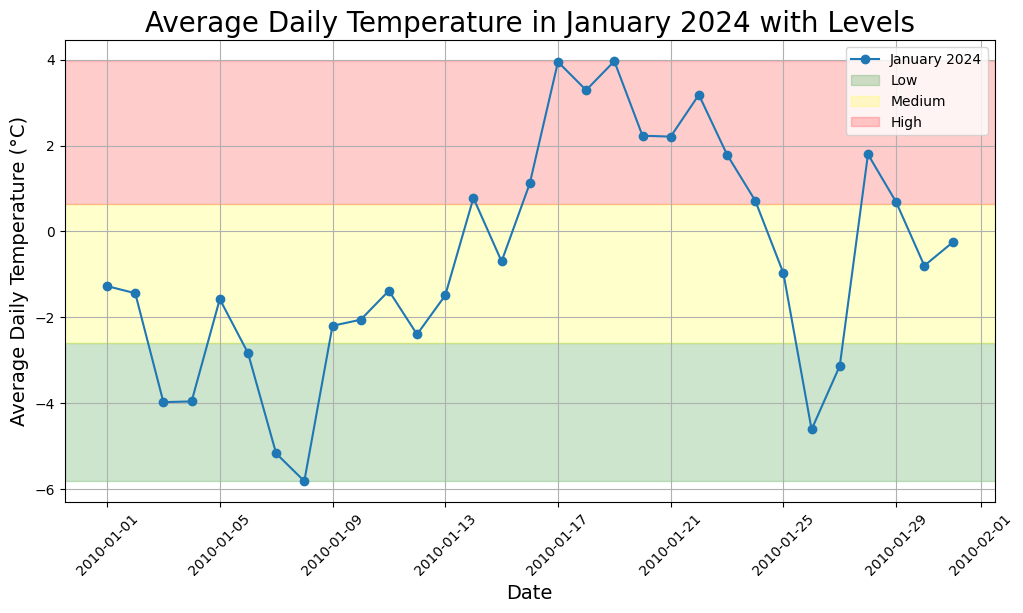

In [13]:
def average_daily(df, weather_var):
    """
    Calculates the average daily weather variable.
    """
    average_daily = df.groupby(['year', 'month', 'day'])[weather_var].mean().reset_index()
    average_daily['date'] = pd.to_datetime(
        average_daily[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))
    return average_daily
# Filter data for January 2024

average_daily_temp = average_daily(all_data, 'temp')
january_2024 = average_daily_temp[
    (average_daily_temp['year'] == 2010) & (average_daily_temp['month'] == 1)
]

# Define thresholds for low, medium, and high levels
low_threshold = january_2024['temp'].min() + (january_2024['temp'].max() - january_2024['temp'].min()) * 0.33
high_threshold = january_2024['temp'].min() + (january_2024['temp'].max() - january_2024['temp'].min()) * 0.66

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(january_2024['date'], january_2024['temp'], marker='o', label='January 2024')

# Add horizontal bands for low, medium, and high levels
plt.axhspan(january_2024['temp'].min(), low_threshold, color='green', alpha=0.2, label='Low')
plt.axhspan(low_threshold, high_threshold, color='yellow', alpha=0.2, label='Medium')
plt.axhspan(high_threshold, january_2024['temp'].max(), color='red', alpha=0.2, label='High')

# Add labels and title
plt.xlabel('Date', size=14)
plt.ylabel('Average Daily Temperature (°C)', size=14)
plt.title('Average Daily Temperature in January 2024 with Levels', size=20)
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

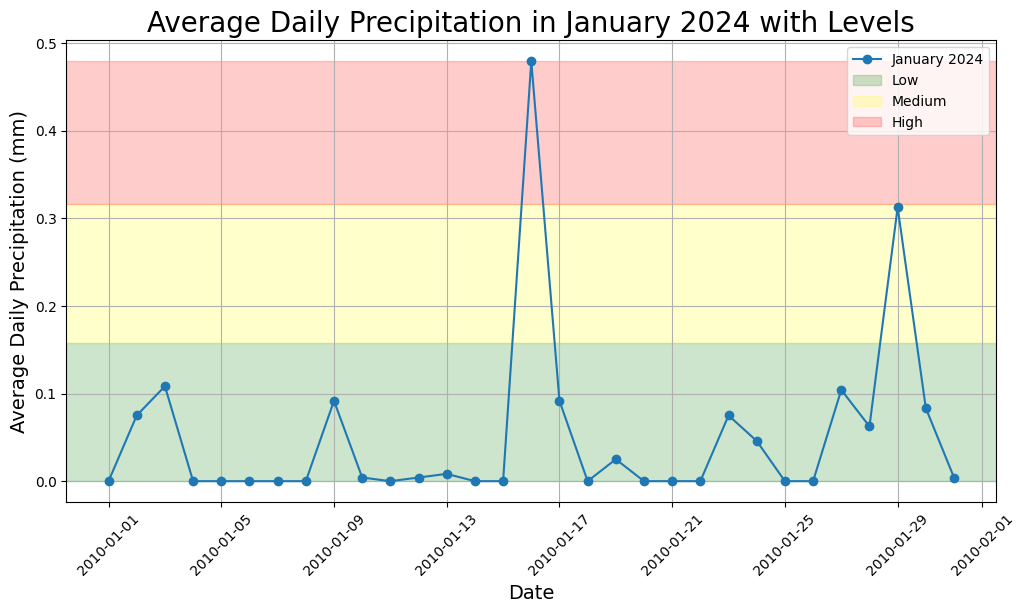

In [14]:

average_daily_temp = average_daily(all_data, 'precip')
january_2024 = average_daily_temp[
    (average_daily_temp['year'] == 2010) & (average_daily_temp['month'] == 1)
]

# Define thresholds for low, medium, and high levels
low_threshold = january_2024['precip'].min() + (january_2024['precip'].max() - january_2024['precip'].min()) * 0.33
high_threshold = january_2024['precip'].min() + (january_2024['precip'].max() - january_2024['precip'].min()) * 0.66

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(january_2024['date'], january_2024['precip'], marker='o', label='January 2024')

# Add horizontal bands for low, medium, and high levels
plt.axhspan(january_2024['precip'].min(), low_threshold, color='green', alpha=0.2, label='Low')
plt.axhspan(low_threshold, high_threshold, color='yellow', alpha=0.2, label='Medium')
plt.axhspan(high_threshold, january_2024['precip'].max(), color='red', alpha=0.2, label='High')

# Add labels and title
plt.xlabel('Date', size=14)
plt.ylabel('Average Daily Precipitation (mm)', size=14)
plt.title('Average Daily Precipitation in January 2024 with Levels', size=20)
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

## Defining Weather States

In [15]:
test_data['temp'] = pd.to_numeric(test_data['temp'], errors='coerce')
test_data['sunshine'] = pd.to_numeric(test_data['sunshine'], errors='coerce')
test_data.dtypes

/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_18998/2214730314.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['temp'] = pd.to_numeric(test_data['temp'], errors='coerce')
/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_18998/2214730314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['sunshine'] = pd.to_numeric(test_data['sunshine'], errors='coerce')


time              datetime64[ns]
sunshine                 float64
temp                     float64
precip                   float64
cloud_cover              float64
wind_speed               float64
month                      int32
day                        int32
year                       int32
minute                     int32
second                     int32
hour                       int32
month_day_time    datetime64[ns]
dtype: object

#### Average the Data

In [16]:
daily_mean_test_df = test_data.select_dtypes(include=[np.number]).groupby(['year', 'month', 'day']).mean().reset_index()

In [17]:
daily_mean_df = all_data.groupby(['year', 'month', 'day']).mean().reset_index()


#### Calculate Monthly Percentiles

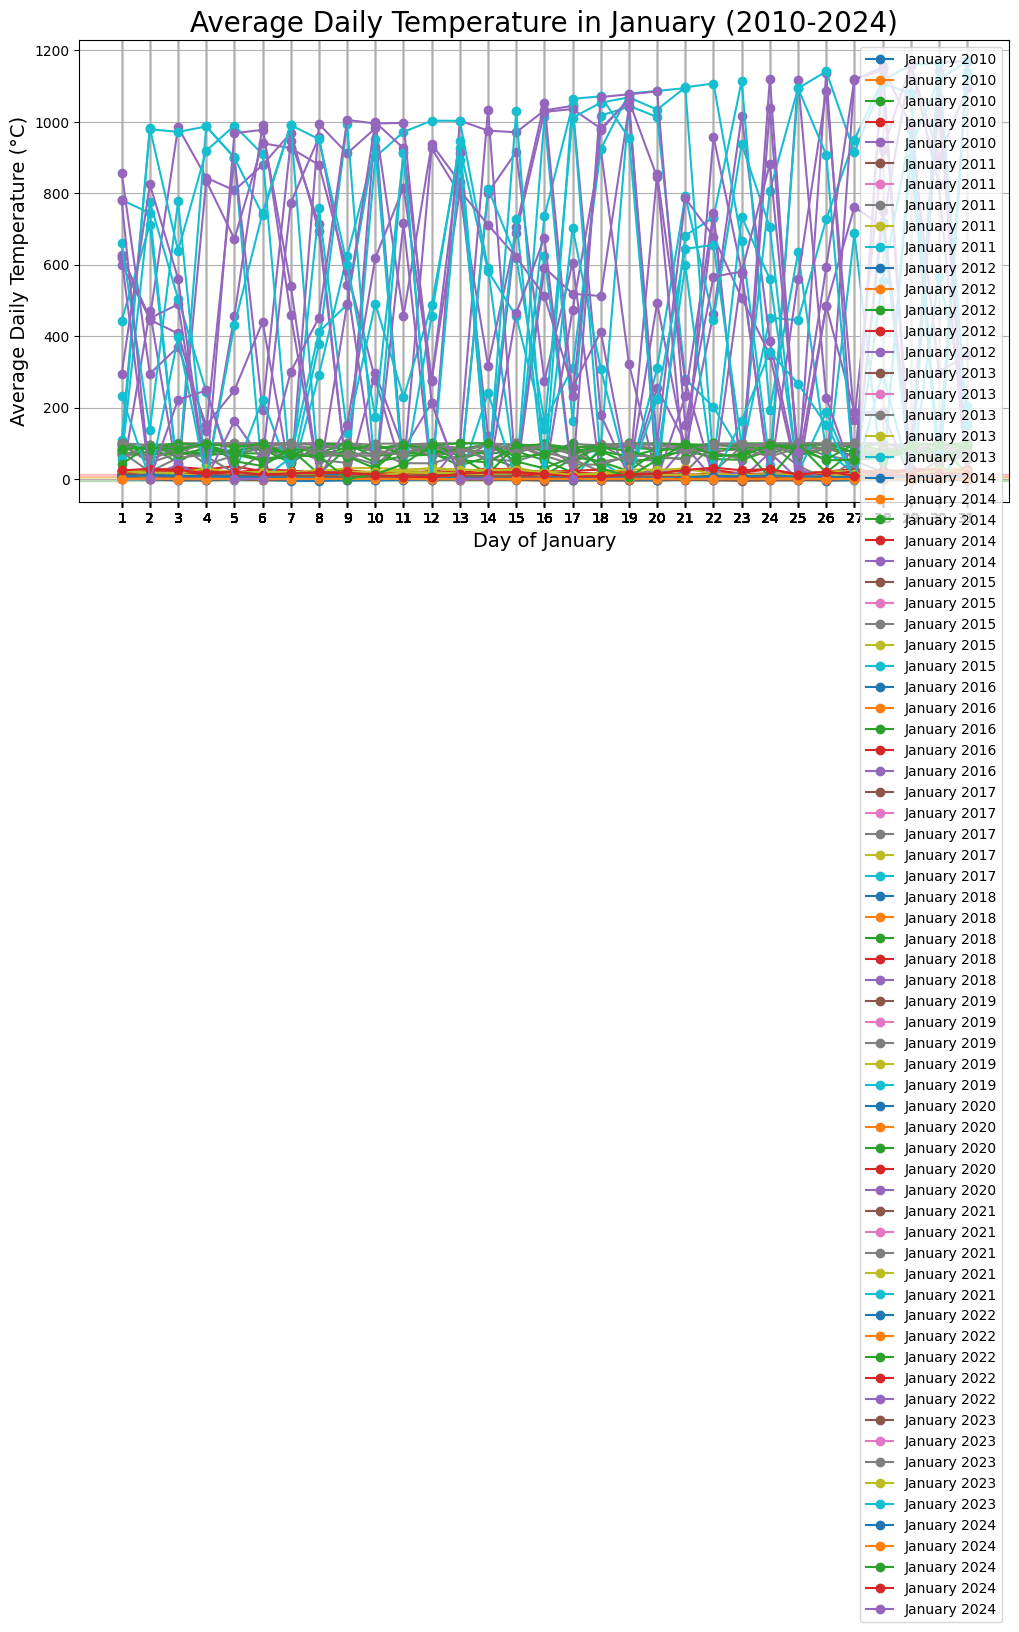

In [18]:
month_data = daily_mean_df[daily_mean_df['month'] == 1]

plt.figure(figsize=(12, 6))
# Plot lines for each year 
for year in range(2010, 2025):
    year_data = month_data[month_data['year'] == year]
    plt.plot(year_data['day'], year_data[weather_var], marker='o', label=f'January {year}')
plt.xlabel('Day of January', size=14)
plt.ylabel('Average Daily Temperature (°C)', size=14)
plt.title('Average Daily Temperature in January (2010-2024)', size=20)
plt.xticks(month_data['day'])
plt.grid()
plt.legend()

weather_var = 'temp'
# Define thresholds for low, medium, and high levels
low_threshold = month_data[weather_var].min() + (month_data[weather_var].max() - month_data[weather_var].min()) * 0.33
high_threshold = month_data[weather_var].min() + (month_data[weather_var].max() - month_data[weather_var].min()) * 0.66

# Add horizontal bands for low, medium, and high levels
plt.axhspan(month_data[weather_var].min(), low_threshold, color='green', alpha=0.2, label='Low')
plt.axhspan(low_threshold, high_threshold, color='yellow', alpha=0.2, label='Medium')
plt.axhspan(high_threshold, month_data[weather_var].max(), color='red', alpha=0.2, label='High')


plt.show()

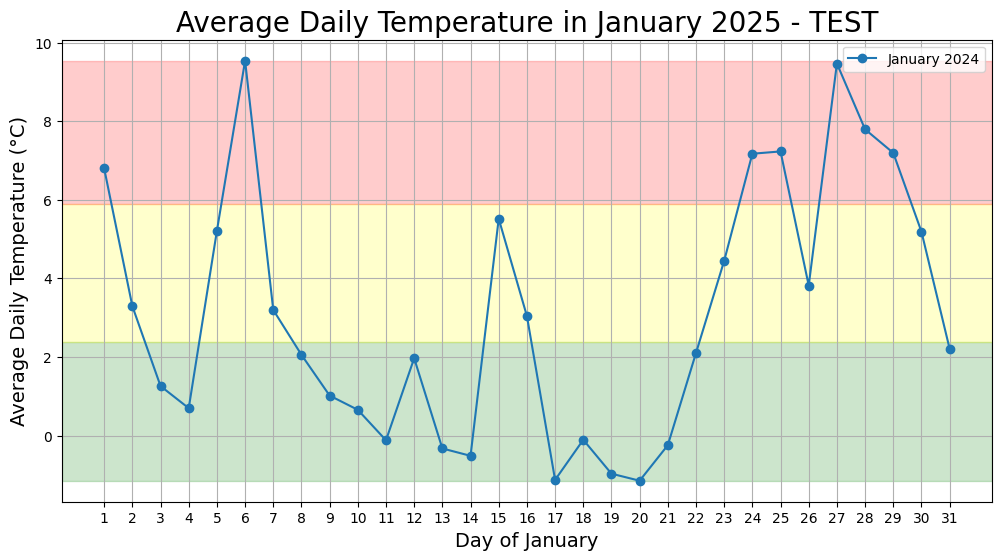

In [19]:

weather_var = 'temp'
plt.figure(figsize=(12, 6))
# Plot lines for each year 

plt.plot(daily_mean_test_df['day'], daily_mean_test_df[weather_var], marker='o', label=f'January {year}')
plt.xlabel('Day of January', size=14)
plt.ylabel('Average Daily Temperature (°C)', size=14)
plt.title('Average Daily Temperature in January 2025 - TEST', size=20)
plt.xticks(daily_mean_test_df['day'])
plt.grid()
plt.legend()


# Define thresholds for low, medium, and high levels
low_threshold = daily_mean_test_df[weather_var].min() + (daily_mean_test_df[weather_var].max() - daily_mean_test_df[weather_var].min()) * 0.33
high_threshold = daily_mean_test_df[weather_var].min() + (daily_mean_test_df[weather_var].max() - daily_mean_test_df[weather_var].min()) * 0.66

# Add horizontal bands for low, medium, and high levels
plt.axhspan(daily_mean_test_df[weather_var].min(), low_threshold, color='green', alpha=0.2, label='Low')
plt.axhspan(low_threshold, high_threshold, color='yellow', alpha=0.2, label='Medium')
plt.axhspan(high_threshold, daily_mean_test_df[weather_var].max(), color='red', alpha=0.2, label='High')


In [20]:
def calculate_percentiles_and_categorize(df, month):
    """
    Calculates percentiles for a specific month and categorizes weather variables into low, medium, and high.
    Includes zero precipitation values in the "Low" category.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing weather data.
        month (int): The month for which to calculate percentiles (1 = January, ..., 12 = December).

    Returns:
        pd.DataFrame: A new DataFrame with additional columns for categorized weather variables.
    """
    # Filter data for the specified month
    month_data = df[df['month'] == month].copy()

    # Calculate percentiles for each weather variable
    thresholds = {}
    for variable in ['temp', 'precip', 'cloud_cover', 'wind_speed', 'sunshine']:
        variable_data = month_data[variable].dropna()

        if variable == 'precip':
            # Include zero values in the "Low" category
            low = np.percentile(variable_data, 33)
            high = np.percentile(variable_data, 66)
            thresholds[variable] = {'low': low, 'high': high}
        else:
            # Standard percentile calculation
            low = np.percentile(variable_data, 33)
            high = np.percentile(variable_data, 66)
            thresholds[variable] = {'low': low, 'high': high}

    # Categorize each variable based on the calculated thresholds
    for variable in thresholds.keys():
        low, high = thresholds[variable]['low'], thresholds[variable]['high']
        month_data[f'{variable}_category'] = month_data[variable].apply(
            lambda x: 'Low' if x <= low else 'Medium' if x < high else 'High'
        )

    return month_data

In [21]:
print(daily_mean_test_df.columns)

Index(['year', 'month', 'day', 'sunshine', 'temp', 'precip', 'cloud_cover',
       'wind_speed', 'minute', 'second', 'hour'],
      dtype='object')


#### Combine Weather Categories into Weather States
Thus each state has n amount of weather categories. \
**There will be different experimental setups:**
1) 2 variables - Temperature and Precipitation
2) 5 variables - Temperature, Precipitation, Wind Speed, Cloud Cover, Sunshine Duration

In [22]:
df_states1 = calculate_percentiles_and_categorize(month_data, 1)


In [23]:
df_states1_test = calculate_percentiles_and_categorize(daily_mean_test_df, 1)

In [24]:
df_states1 = df_states1[['year', 'month', 'day', 'temp_category', 'precip_category', 'cloud_cover_category', 'wind_speed_category', 'sunshine_category']]
df_states1_test = df_states1_test[['year', 'month', 'day', 'temp_category', 'precip_category', 'cloud_cover_category', 'wind_speed_category', 'sunshine_category']]

In [25]:
# 1st Experiment - 2 variables - Temperature and Precipitation
# combine categories into 2 variable state
df_states1['state1'] = df_states1[['temp_category', 'precip_category']].agg('-'.join, axis=1)
df_states1_test['state1_test'] = df_states1_test[['temp_category', 'precip_category']].agg('-'.join, axis=1)

In [26]:
print(df_states1['precip_category'].unique())
print(df_states1['temp_category'].unique())

['Low' 'Medium' 'High']
['Low' 'Medium' 'High']


In [27]:
# make df_states1 a csv file
df_states1.to_csv('data/df_states1.csv', index=False)

In [28]:
df_states1['state1'].unique()

array(['Low-Low', 'Low-Medium', 'Low-High', 'Medium-High', 'Medium-Low',
       'Medium-Medium', 'High-High', 'High-Medium', 'High-Low'],
      dtype=object)

In [29]:
df_states1_test['state1_test'].unique()

array(['High-High', 'Medium-High', 'Medium-Medium', 'Low-Medium',
       'Low-High', 'Medium-Low', 'Low-Low', 'High-Medium'], dtype=object)

#### Creating Transition Matrix 

In [30]:
df = df_states1[['state1']].copy()
df_test = df_states1_test[['state1_test']].copy()

In [31]:
# Define the next state
df['next_state'] = df['state1'].shift(-1)
# Drop the last row since it has no next state
df = df.dropna(subset=['next_state'])
# Create a transition matrix with raw counts
transition_counts = pd.crosstab(df['state1'], df['next_state'])

print(df)

           state1   next_state
0         Low-Low   Low-Medium
1      Low-Medium     Low-High
2        Low-High      Low-Low
3         Low-Low      Low-Low
4         Low-Low      Low-Low
...           ...          ...
5138    High-High   Medium-Low
5139   Medium-Low   Medium-Low
5140   Medium-Low     High-Low
5141     High-Low  High-Medium
5142  High-Medium     High-Low

[464 rows x 2 columns]


In [32]:
# count amounts of states in the state1 column
state_counts = df['state1'].value_counts()
next_state_counts = df['next_state'].value_counts()

In [33]:
print(transition_counts)

next_state     High-High  High-Low  High-Medium  Low-High  Low-Low  \
state1                                                               
High-High             40         6           18         0        0   
High-Low               8         6            7         0        0   
High-Medium           16         4            8         0        0   
Low-High               0         1            0         5        7   
Low-Low                3         1            1        10       52   
Low-Medium             1         2            1         5       17   
Medium-High            7         0            2         5        3   
Medium-Low             8         2            3         0        7   
Medium-Medium          8         3            2         3        3   

next_state     Low-Medium  Medium-High  Medium-Low  Medium-Medium  
state1                                                             
High-High               2            8           4             13  
High-Low                0

In [34]:
# Normalize the transition counts to calculate probabilities
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)
# Fill NaN values with 0 (in case some rows have no transitions)
transition_matrix = transition_matrix.fillna(0)
# Print the transition matrix
print(transition_matrix)

next_state     High-High  High-Low  High-Medium  Low-High   Low-Low  \
state1                                                                
High-High       0.439560  0.065934     0.197802  0.000000  0.000000   
High-Low        0.333333  0.250000     0.291667  0.000000  0.000000   
High-Medium     0.380952  0.095238     0.190476  0.000000  0.000000   
Low-High        0.000000  0.035714     0.000000  0.178571  0.250000   
Low-Low         0.033333  0.011111     0.011111  0.111111  0.577778   
Low-Medium      0.027778  0.055556     0.027778  0.138889  0.472222   
Medium-High     0.142857  0.000000     0.040816  0.102041  0.061224   
Medium-Low      0.181818  0.045455     0.068182  0.000000  0.159091   
Medium-Medium   0.133333  0.050000     0.033333  0.050000  0.050000   

next_state     Low-Medium  Medium-High  Medium-Low  Medium-Medium  
state1                                                             
High-High        0.021978     0.087912    0.043956       0.142857  
High-Low      

In [35]:
# Verify that rows sum to 1
row_sums = transition_matrix.sum(axis=1)
print("Row sums (should all be 1):")
print(row_sums)

Row sums (should all be 1):
state1
High-High        1.0
High-Low         1.0
High-Medium      1.0
Low-High         1.0
Low-Low          1.0
Low-Medium       1.0
Medium-High      1.0
Medium-Low       1.0
Medium-Medium    1.0
dtype: float64


## Markov Chain Implementation 

In [56]:
def compare_sequences_with_test(simulated_sequences, test_sequence, states, top_n=5):
    """
    Find and visualize the top N simulated sequences most similar to the test sequence
    
    Args:
        simulated_sequences: List of simulated sequences from Monte Carlo
        test_sequence: The real/test sequence to compare against
        states: List of all possible weather states
        top_n: Number of most similar sequences to return (default: 5)
        
    Returns:
        Dictionary with similarity metrics and top sequences
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    
    # Ensure sequences are of the same length by truncating the longer one
    seq_length = min(len(test_sequence), min(len(seq) for seq in simulated_sequences))
    test_seq_trimmed = test_sequence[:seq_length]
    
    # 1. Define similarity metrics between sequences
    def calculate_similarity_metrics(seq1, seq2):
        # Hamming distance (number of positions where states match)
        hamming_matches = sum(1 for i in range(seq_length) if seq1[i] == seq2[i])
        hamming_similarity = hamming_matches / seq_length
        
        # Transition pattern similarity (how many consecutive state pairs match)
        transition_matches = sum(1 for i in range(seq_length-1) 
                               if seq1[i:i+2] == seq2[i:i+2])
        transition_similarity = transition_matches / (seq_length - 1) if seq_length > 1 else 0
        
        # State distribution similarity
        # Count occurrences of each state
        states_seq1 = Counter(seq1)
        states_seq2 = Counter(seq2)
        
        # Calculate cosine similarity between state frequency vectors
        numerator = sum(states_seq1.get(state, 0) * states_seq2.get(state, 0) for state in states)
        denom1 = sum(states_seq1.get(state, 0)**2 for state in states)**0.5
        denom2 = sum(states_seq2.get(state, 0)**2 for state in states)**0.5
        
        distribution_similarity = numerator / (denom1 * denom2) if denom1 * denom2 > 0 else 0
        
        # Combine metrics (weighted average)
        overall_similarity = (0.4 * hamming_similarity + 
                             0.4 * transition_similarity + 
                             0.2 * distribution_similarity)
        
        return {
            'hamming_similarity': hamming_similarity,
            'transition_similarity': transition_similarity,
            'distribution_similarity': distribution_similarity,
            'overall_similarity': overall_similarity
        }
    
    # 2. Calculate similarity for all simulated sequences
    similarities = []
    for i, sequence in enumerate(simulated_sequences):
        seq_trimmed = sequence[:seq_length]
        metrics = calculate_similarity_metrics(test_seq_trimmed, seq_trimmed)
        similarities.append({
            'index': i,
            'sequence': seq_trimmed,
            'metrics': metrics
        })
    
    # 3. Sort sequences by overall similarity and get top N
    similarities.sort(key=lambda x: x['metrics']['overall_similarity'], reverse=True)
    top_sequences = similarities[:top_n]
    
    # 4. Visualize the comparison
    # Create a color map for states
    # Define a set of pastel base colors

    
    cmap = plt.cm.get_cmap('Pastel1', len(states))
    color_map = {state: cmap(i) for i, state in enumerate(states)}
    
    # Create figure with appropriate height based on number of sequences
    plt.figure(figsize=(15, 2 + top_n))
    
    # Plot test sequence at the top
    ax1 = plt.subplot(top_n + 1, 1, 1)
    for i in range(seq_length):
        rect = plt.Rectangle((i, 0), 1, 1, color=color_map[test_seq_trimmed[i]])
        ax1.add_patch(rect)
    ax1.set_xlim(0, seq_length)
    ax1.set_ylim(0, 1)
    ax1.set_yticks([])
    ax1.set_title('Test Sequence')
    ax1.set_xticks([])
    
    # Plot top similar sequences
    for idx, seq_data in enumerate(top_sequences):
        ax = plt.subplot(top_n + 1, 1, idx + 2)
        sequence = seq_data['sequence']
        similarity = seq_data['metrics']['overall_similarity']
        
        # Plot colored rectangles for each state
        for i in range(seq_length):
            rect = plt.Rectangle((i, 0), 1, 1, color=color_map[sequence[i]])
            ax.add_patch(rect)
        
        ax.set_xlim(0, seq_length)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_title(f'Sequence #{seq_data["index"]}, Similarity: {similarity:.3f}')
        
        # Only add x-ticks to the bottom subplot
        if idx == top_n - 1:
            ax.set_xticks(range(seq_length))
            ax.set_xticklabels([f'Day {i+1}' for i in range(seq_length)])
        else:
            ax.set_xticks([])
    
    # Add a legend for state colors
    handles = [plt.Rectangle((0,0), 1, 1, color=color_map[state]) for state in states]
    fig = plt.gcf()
    fig.legend(handles, states, loc='upper center', bbox_to_anchor=(0.5, 0), 
              ncol=min(5, len(states)))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for the legend
    plt.savefig('sequence_comparison.png')
    
    # 5. Print similarity statistics
    print("\n=== Top 5 Most Similar Sequences ===")
    for idx, seq_data in enumerate(top_sequences):
        metrics = seq_data['metrics']
        print(f"Sequence #{seq_data['index']}:")
        print(f"  Overall Similarity: {metrics['overall_similarity']:.3f}")
        print(f"  Matching Positions: {metrics['hamming_similarity']*100:.1f}%")
        print(f"  Matching Transitions: {metrics['transition_similarity']*100:.1f}%")
        print(f"  State Distribution Similarity: {metrics['distribution_similarity']*100:.1f}%")
    
    # Return the results
    return {
        'top_sequences': top_sequences,
        'all_similarities': similarities,
        'test_sequence': test_seq_trimmed
    }

In [58]:
def simulate_markov_chain(transition_matrix, states, initial_state, steps):
    '''
    Simulates a Markov Chain
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states
        initial_state: Starting state for the simulation
        steps: Number of steps to simulate
        
    Returns:
        List of states in the simulated sequence
    '''

    # initialise current state
    current_state = initial_state
    
    # add current state to the list of sequences 
    state_sequence = [current_state]
    
    # generate n steps of states
    for _ in range(steps):
        # get probability for the current state
        probabilities = transition_matrix.loc[current_state].values
        # choose the next state based on the probabilities 
        next_state = np.random.choice(states, p=probabilities)
        state_sequence.append(next_state)
        current_state = next_state
    
    return state_sequence


def monte_carlo_markov_chain(transition_matrix, states, initial_state=None, steps=31, n_simulations=1000):
    '''
    Performs Monte Carlo simulation of a Markov Chain
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states
        initial_state: Starting state (if None, will be randomly chosen based on stationary distribution)
        steps: Number of steps to simulate in each run
        n_simulations: Number of simulations to run
        
    Returns:
        Dictionary containing:
        - 'mean_counts': Average count of each state across all simulations
        - 'std_counts': Standard deviation of counts for each state
        - 'ci_lower', 'ci_upper': 95% confidence intervals for state frequencies
        - 'all_sequences': List of all simulated sequences (optional, can be removed if memory is a concern)
    '''


    # Initialize storage for all simulations
    all_sequences = []
    all_counts = {state: [] for state in states}

    # If no initial state is provided, use stationary distribution to choose one
    if initial_state is None:
        # Approximate stationary distribution by raising transition matrix to high power
        # This requires transition_matrix to be a numpy array, so convert if needed
        if isinstance(transition_matrix, pd.DataFrame):
            tm_numpy = transition_matrix.values
        else:
            tm_numpy = transition_matrix
            
        # Initialize a uniform distribution
        p = np.ones(len(states)) / len(states)
        
        # Multiply by transition matrix multiple times to approximate stationary distribution
        for _ in range(100):  # Usually 100 iterations is enough for convergence
            p = p @ tm_numpy
            
        # Choose initial state based on stationary distribution
        initial_state = np.random.choice(states, p=p)
    
    # Run n_simulations
    for _ in range(n_simulations):
        # For each simulation, potentially use a different initial state from stationary distribution
        if initial_state is None:
            sim_initial_state = np.random.choice(states, p=p)
        else:
            sim_initial_state = initial_state
            
        # Run one simulation
        sequence = simulate_markov_chain(transition_matrix, states, sim_initial_state, steps)
        all_sequences.append(sequence)
        
        # Count occurrences of each state in this simulation
        counts = Counter(sequence)
        for state in states:
            all_counts[state].append(counts.get(state, 0))
    
    # Calculate statistics
    mean_counts = {state: np.mean(counts) for state, counts in all_counts.items()}
    std_counts = {state: np.std(counts) for state, counts in all_counts.items()}
    
    # Calculate 95% confidence intervals
    ci_lower = {state: np.percentile(counts, 2.5) for state, counts in all_counts.items()}
    ci_upper = {state: np.percentile(counts, 97.5) for state, counts in all_counts.items()}
    
    return {
        'mean_counts': mean_counts,
        'std_counts': std_counts,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'all_sequences': all_sequences  # Optional: can be removed to save memory
    }


def analyze_monte_carlo_results(mc_results, real_data, states, test_sequence=None):
    '''
    Analyzes and visualizes the results of Monte Carlo simulation
    
    Args:
        mc_results: Results from monte_carlo_markov_chain function
        real_data: Dictionary or Counter with actual observed frequencies
        states: List of possible states
        test_sequence: Optional test sequence to compare with simulated sequences
        
    Returns:
        Dictionary with analysis metrics
    '''
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import chisquare
    
    # Extract results
    mean_counts = mc_results['mean_counts']
    std_counts = mc_results['std_counts']
    ci_lower = mc_results['ci_lower']
    ci_upper = mc_results['ci_upper']
    
    # Prepare data for visualization
    simulated_means = [mean_counts[state] for state in states]
    error_bars = [std_counts[state] for state in states]
    real_counts = [real_data.get(state, 0) for state in states]
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    x = np.arange(len(states))
    width = 0.35
    
    plt.bar(x - width/2, simulated_means, width, label='Simulated (Monte Carlo)', yerr=error_bars, alpha=0.7)
    plt.bar(x + width/2, real_counts, width, label='Real Data', alpha=0.7)
    
    plt.xlabel('Weather States')
    plt.ylabel('Frequency')
    plt.title('Monte Carlo Simulation vs. Real Weather States')
    plt.xticks(x, states, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    
    # Save figure
    plt.savefig('monte_carlo_analysis.png')
    
    # Calculate Chi-square statistic
    chi2_stat, p_value = chisquare(f_obs=real_counts, f_exp=simulated_means)
    
    # Calculate mean absolute error
    mae = np.mean([abs(real_counts[i] - simulated_means[i]) for i in range(len(states))])
    mse = np.mean([(real_counts[i] - simulated_means[i])**2 for i in range(len(states))])
    mape = np.mean([abs(real_counts[i] - simulated_means[i]) / real_counts[i] for i in range(len(states)) if real_counts[i] != 0])
    
    # Check if real values fall within confidence intervals
    within_ci = [ci_lower[state] <= real_data.get(state, 0) <= ci_upper[state] for state in states]
    percent_within_ci = sum(within_ci) / len(states) * 100

    # Add sequence comparison if a test sequence is provided
    sequence_comparison = None
    if test_sequence is not None:
        sequence_comparison = compare_sequences_with_test(
            mc_results['all_sequences'], test_sequence, states)
    
    # Prepare results
    results = {
        'chi2_statistic': chi2_stat,
        'p_value': p_value,
        'statistically_similar': p_value > 0.05,
        'mean_absolute_error': mae,
        'mean_squared_error': mse,
        'mean_absolute_percentage_error': mape,
        'percent_within_ci': percent_within_ci,
        'states_outside_ci': [states[i] for i in range(len(states)) if not within_ci[i]],
        'sequence_comparison': sequence_comparison
    }
    
    # Print summary
    print(f"Chi-square statistic: {chi2_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Distributions are statistically similar: {p_value > 0.05}")
    print(f"Mean absolute error: {mae:.2f}")
    print(f"Mean squared error: {mse:.2f}")
    print(f"Mean absolute percentage error: {mape:.2f}")
    print(f"Percentage of states within 95% CI: {percent_within_ci:.1f}%")
    print(f"States outside confidence intervals: {results['states_outside_ci']}")
    
    return results

In [59]:
# List of all states
all_states = transition_matrix.index.tolist()

# Initial state (choose one from the list of states)
initial_state = np.random.choice(all_states) 

# Number of steps to simulate
steps = 30

# Simulate the Markov Chain
state_sequence = simulate_markov_chain(transition_matrix, all_states, initial_state, steps)

# Print the simulated sequence
print("Simulated State Sequence:")
print(state_sequence)



Simulated State Sequence:
[np.str_('Low-High'), np.str_('Low-Medium'), np.str_('Low-High'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Medium-Medium'), np.str_('Medium-Low'), np.str_('Medium-Low'), np.str_('Medium-Medium'), np.str_('Medium-Medium'), np.str_('Low-Low'), np.str_('Low-Medium'), np.str_('Low-Medium'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Medium'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Medium-Low'), np.str_('High-High'), np.str_('High-High'), np.str_('High-High'), np.str_('High-High'), np.str_('Medium-Low'), np.str_('Medium-Low'), np.str_('High-Medium')]


In [60]:
# Convert np.str_ objects to regular Python strings
state_list = [str(item) for item in state_sequence]
state_list

['Low-High',
 'Low-Medium',
 'Low-High',
 'Low-Low',
 'Low-Low',
 'Medium-Medium',
 'Medium-Low',
 'Medium-Low',
 'Medium-Medium',
 'Medium-Medium',
 'Low-Low',
 'Low-Medium',
 'Low-Medium',
 'Low-Low',
 'Low-Low',
 'Low-Low',
 'Low-Low',
 'Low-Low',
 'Low-Low',
 'Low-Low',
 'Low-Medium',
 'Low-Low',
 'Low-Low',
 'Medium-Low',
 'High-High',
 'High-High',
 'High-High',
 'High-High',
 'Medium-Low',
 'Medium-Low',
 'High-Medium']

In [61]:
# import matplotlib.pyplot as plt

# Count the frequency of each state
from collections import Counter
state_counts = Counter(state_sequence)

state_sequence_test = []
for i in df_test['state1_test']:
    state_sequence_test.append(i)

state_counts_test = Counter(state_sequence_test)

# # Plot the state frequencies
# plt.bar(state_counts.keys(), state_counts.values())
# # plt.bar(state_counts_test.keys(), state_counts_test.values())
# plt.xlabel('States')
# plt.ylabel('Frequency')
# plt.title('State Frequencies in Simulated Markov Chain')
# plt.xticks(rotation=90)
# plt.show()

In [62]:
# import matplotlib.pyplot as plt
# from collections import Counter


# # Plot the state frequencies
# plt.bar(state_counts_test.keys(), state_counts_test.values())
# plt.xlabel('States')
# plt.ylabel('Frequency')
# plt.title('State Frequencies in Jan 2025')
# plt.xticks(rotation=90)
# plt.show()

In [63]:
# print(f'simulated {state_counts}')
# print(f'test {state_counts_test}')
# # Extract keys and values
# labels = list(state_counts.keys())
# values1 = [state_counts[key] for key in labels]
# values2 = [state_counts_test[key] for key in labels]

# # Set up bar width and positions
# x = np.arange(len(labels))  # the label locations
# width = 0.35  # width of the bars

# # Create the plot
# fig, ax = plt.subplots()
# bars1 = ax.bar(x - width/2, values1, width, label='Simulated')
# bars2 = ax.bar(x + width/2, values2, width, label='Real')

# # Add labels and legend
# ax.set_xlabel('States')
# ax.set_ylabel('Frequency')
# ax.set_title('Side-by-Side Comparison of Weather State Frequencies')
# ax.set_xticks(x)
# ax.set_xticklabels(labels, rotation= 90)
# ax.legend()

# # Show plot
# plt.tight_layout()
# plt.show()

/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_18998/3033031174.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Pastel1', len(states))



=== Top 5 Most Similar Sequences ===
Sequence #266:
  Overall Similarity: 0.403
  Matching Positions: 32.3%
  Matching Transitions: 23.3%
  State Distribution Similarity: 90.2%
Sequence #589:
  Overall Similarity: 0.401
  Matching Positions: 35.5%
  Matching Transitions: 20.0%
  State Distribution Similarity: 89.7%
Sequence #975:
  Overall Similarity: 0.401
  Matching Positions: 35.5%
  Matching Transitions: 16.7%
  State Distribution Similarity: 96.3%
Sequence #576:
  Overall Similarity: 0.397
  Matching Positions: 38.7%
  Matching Transitions: 20.0%
  State Distribution Similarity: 80.9%
Sequence #218:
  Overall Similarity: 0.387
  Matching Positions: 29.0%
  Matching Transitions: 20.0%
  State Distribution Similarity: 95.5%
Chi-square statistic: 3.2550
p-value: 0.9173
Distributions are statistically similar: True
Mean absolute error: 0.82
Mean squared error: 0.98
Mean absolute percentage error: 0.23
Percentage of states within 95% CI: 100.0%
States outside confidence intervals: []


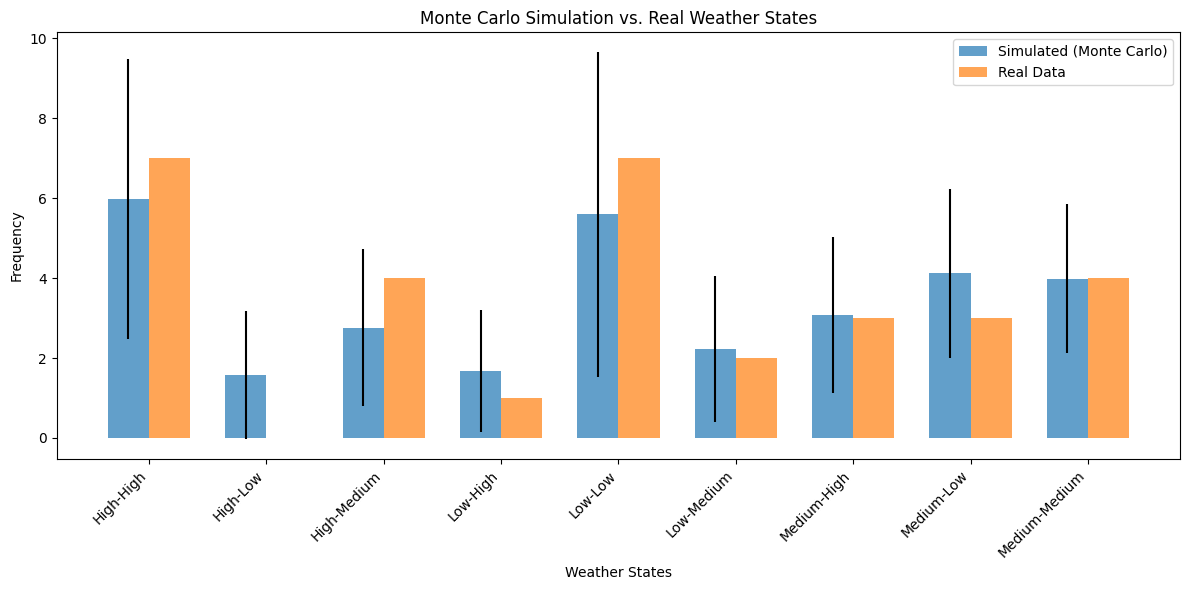

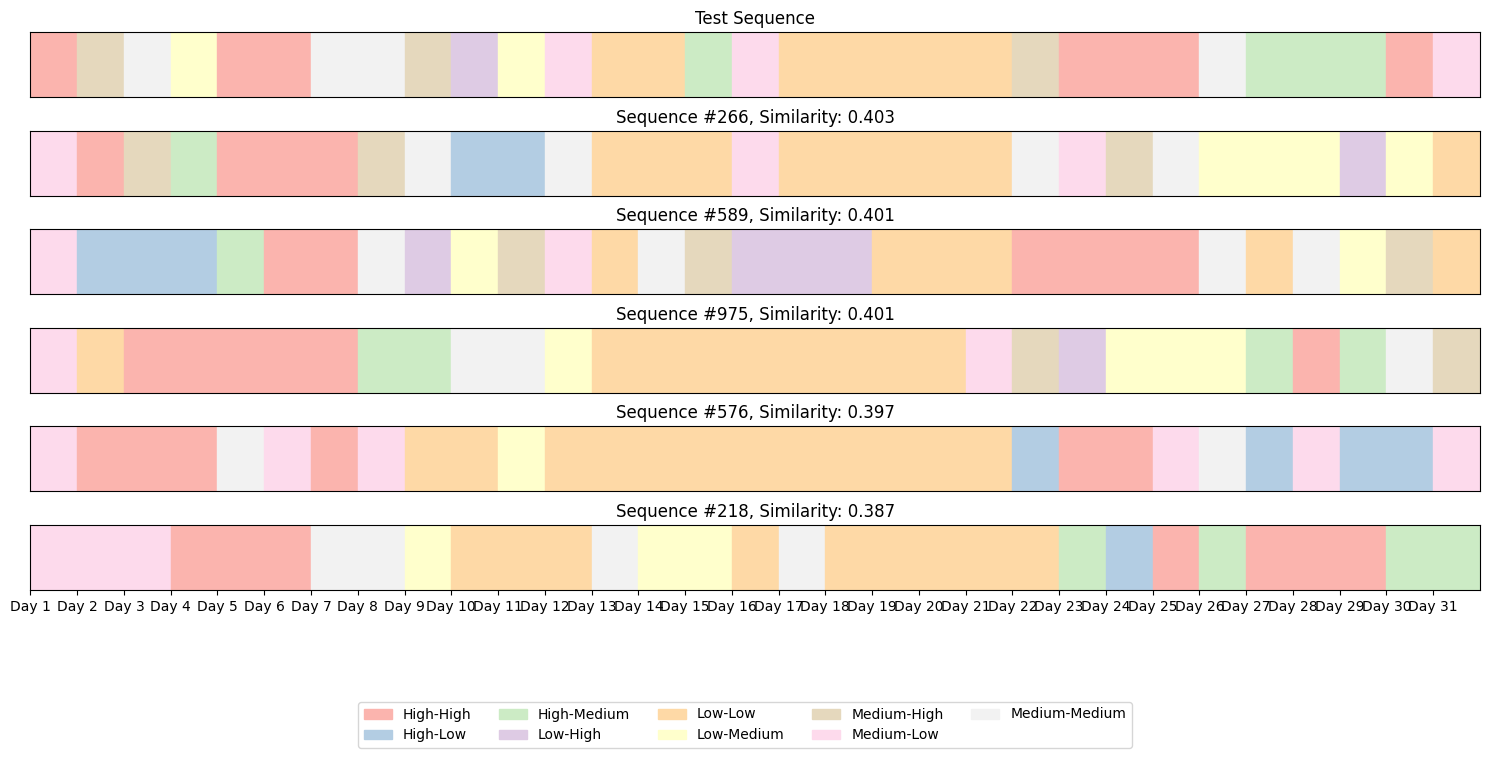

In [64]:
# Run Monte Carlo simulation
mc_results = monte_carlo_markov_chain(
    transition_matrix=transition_matrix,
    states=all_states, 
    steps=30,  # for January
    n_simulations=1000, 
)

# Analyze results
analysis = analyze_monte_carlo_results(
    mc_results=mc_results,
    real_data=state_counts_test, 
    states=all_states,
    test_sequence= state_sequence_test
)

# Constraint Implementation

### One Day Constraint 

In [67]:
def implement_one_day_constraint(transition_matrix, states, target_state, boost_factor=1.5):
    """
    Modify transition matrix to increase probability of visiting the target state
    
    Args:
        transition_matrix: Original transition matrix (Pandas DataFrame)
        states: List of possible states
        target_state: The state that must appear at least once
        boost_factor: Factor to increase transition probabilities to target state
        
    Returns:
        Modified transition matrix
    """
    # Create a copy of the transition matrix
    modified_matrix = transition_matrix.copy()
    
    # Boost probabilities of transitioning to the target state
    for state in states:
        if state != target_state:  # Skip self-transitions from target state
            # Get current probability of transitioning to target state
            current_prob = modified_matrix.loc[state, target_state]
            
            # Calculate boost (ensuring probabilities still sum to 1)
            boost = current_prob * (boost_factor - 1)
            
            # Apply boost to target state transition
            modified_matrix.loc[state, target_state] += boost
            
            # Reduce other probabilities proportionally
            other_states = [s for s in states if s != target_state]
            other_probs_sum = modified_matrix.loc[state, other_states].sum()
            
            if other_probs_sum > 0:  # Avoid division by zero
                reduction_factor = (other_probs_sum - boost) / other_probs_sum
                for other_state in other_states:
                    modified_matrix.loc[state, other_state] *= reduction_factor
    
    # Ensure rows still sum to 1 (handle numerical precision issues)
    for state in states:
        row_sum = modified_matrix.loc[state].sum()
        if abs(row_sum - 1.0) > 1e-10:  # If not very close to 1
            modified_matrix.loc[state] /= row_sum
    
    return modified_matrix

def generate_one_day_constraint_sequence(transition_matrix, states, target_state, 
                                        initial_state=None, steps=30):
    """
    Generate a sequence with at least one occurrence of target_state
    
    Args:
        transition_matrix: Your transition probability matrix (Pandas DataFrame)
        states: List of possible weather states
        target_state: State that must appear at least once
        initial_state: Starting state (if None, will be randomly selected)
        steps: Number of days to generate
        
    Returns:
        A sequence that contains at least one occurrence of target_state
    """
    # First try with modified transition matrix
    modified_matrix = implement_one_day_constraint(transition_matrix, states, target_state)
    
    # If no initial state is provided, select one randomly
    if initial_state is None:
        initial_state = np.random.choice(states)
    
    # Generate sequence with modified matrix
    sequence = simulate_markov_chain(modified_matrix, states, initial_state, steps)
    
    # Check if target state appears in the sequence
    if target_state in sequence:
        return sequence
    
    # If target state doesn't appear (which is unlikely but possible),
    # insert it at a random position
    insert_position = np.random.randint(0, len(sequence))
    sequence[insert_position] = target_state
    
    return sequence

In [71]:
def analyze_one_day_constraint_effect(transition_matrix, states, target_state, 
                                    real_data=None, test_sequence=None, n_simulations=1000, steps=30):
    """
    Analyze the effect of the one day constraint by comparing with unconstrained model
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states  
        target_state: State that must appear at least once
        real_data: Optional dictionary or Counter with actual observed frequencies
        test_sequence: Optional test sequence to compare with simulated sequences
        n_simulations: Number of simulations to run
        steps: Number of steps to simulate in each run
        
    Returns:
        Dictionary with analysis metrics
    """
    # Import necessary libraries if not already imported
    from scipy.stats import chisquare
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Run Monte Carlo simulations
    print(f"Running Monte Carlo simulation with one day constraint for '{target_state}'...")
    constrained_results = monte_carlo_with_one_day_constraint(
        transition_matrix, states, target_state, steps=steps, n_simulations=n_simulations)
    
    print(f"Running Monte Carlo simulation without constraints for comparison...")
    unconstrained_results = monte_carlo_markov_chain(
        transition_matrix, states, steps=steps, n_simulations=n_simulations)
    
    # Extract statistical results
    constrained_means = constrained_results['mean_counts']
    constrained_stds = constrained_results['std_counts']
    
    unconstrained_means = unconstrained_results['mean_counts']
    unconstrained_stds = unconstrained_results['std_counts']
    
    # Calculate constraint satisfaction rate
    # Count sequences with at least one occurrence of target state
    constrained_sequences = constrained_results['all_sequences']
    unconstrained_sequences = unconstrained_results['all_sequences']
    
    const_with_target = sum(1 for seq in constrained_sequences if target_state in seq)
    unconst_with_target = sum(1 for seq in unconstrained_sequences if target_state in seq)
    
    const_satisfaction_rate = const_with_target / n_simulations * 100
    unconst_satisfaction_rate = unconst_with_target / n_simulations * 100
    
    # Prepare data for visualization (state comparison)
    plt.figure(figsize=(12, 6))
    x = np.arange(len(states))
    width = 0.35
    
    # Set means for visualization
    vis_const_means = [constrained_means.get(state, 0) for state in states]
    vis_unconst_means = [unconstrained_means.get(state, 0) for state in states]
    
    # Set standard deviations for error bars
    vis_const_stds = [constrained_stds.get(state, 0) for state in states]
    vis_unconst_stds = [unconstrained_stds.get(state, 0) for state in states]
    
    # Create bar plot
    plt.bar(x - width/2, vis_unconst_means, width, yerr=vis_unconst_stds, 
            label='Unconstrained', alpha=0.7)
    plt.bar(x + width/2, vis_const_means, width, yerr=vis_const_stds, 
            label=f'One Day Constraint ({target_state})', alpha=0.7)
    
    # Add real data if provided
    if real_data is not None:
        real_counts = [real_data.get(state, 0) for state in states]
        plt.plot(x, real_counts, 'ro', label='Real Data', markersize=8)
        
    # Format plot    
    plt.xlabel('Weather States')
    plt.ylabel('Frequency')
    plt.title(f'Effect of One Day Constraint (Target: {target_state})')
    plt.xticks(x, states, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig('one_day_constraint_analysis.png')
    
    # Calculate impact on target state frequency
    target_constrained = constrained_means.get(target_state, 0)
    target_unconstrained = unconstrained_means.get(target_state, 0)
    target_diff = target_constrained - target_unconstrained
    target_percent_change = (target_diff / target_unconstrained) * 100 if target_unconstrained > 0 else float('inf')
    
    # Calculate statistics
    # Prepare vectors for chi-square test
    const_vector = [constrained_means.get(state, 0) for state in states]
    unconst_vector = [unconstrained_means.get(state, 0) for state in states]
    
    # Run chi-square test
    chi2_stat, p_value = chisquare(const_vector, f_exp=unconst_vector)
    
    # Calculate mean absolute error between constrained and unconstrained
    mae = np.mean([abs(constrained_means.get(state, 0) - unconstrained_means.get(state, 0)) 
                  for state in states])
    
    # Calculate state impacts
    state_impacts = {}
    for state in states:
        diff = constrained_means[state] - unconstrained_means[state]
        state_impacts[state] = diff
    
    # Find states with largest changes
    sorted_impacts = sorted(state_impacts.items(), key=lambda x: abs(x[1]), reverse=True)
    
    # Analyze target state occurrence patterns
    # Distribution of target state positions in sequences
    target_positions = []
    for sequence in constrained_sequences:
        positions = [i for i, state in enumerate(sequence) if state == target_state]
        target_positions.extend(positions)
    
    # Visualize distribution of target state positions
    plt.figure(figsize=(10, 6))
    plt.hist(target_positions, bins=steps, alpha=0.7)
    plt.xlabel('Position in Sequence (Day)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {target_state} Positions in Constrained Sequences')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('one_day_constraint_positions.png')
    
    # Add sequence comparison if a test sequence is provided
    sequence_comparison = None
    if test_sequence is not None:
        print("Comparing constrained sequences with test sequence...")
        sequence_comparison = compare_sequences_with_test(
            constrained_results['all_sequences'], test_sequence, states)
    
    # Print summary statistics
    print("\n=== One Day Constraint Analysis Results ===")
    print(f"Target state: {target_state}")
    print(f"Constraint satisfaction:")
    print(f"  Constrained model: {const_satisfaction_rate:.1f}% of sequences contain target state")
    print(f"  Unconstrained model: {unconst_satisfaction_rate:.1f}% of sequences contain target state")
    
    print(f"\nTarget state frequency:")
    print(f"  Unconstrained: {target_unconstrained:.2f} days")
    print(f"  Constrained: {target_constrained:.2f} days")
    print(f"  Difference: {target_diff:+.2f} days ({target_percent_change:+.1f}%)")
    
    print(f"\nChi-square test:")
    print(f"  Chi-square statistic: {chi2_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Distributions are {'not ' if p_value < 0.05 else ''}statistically similar")
    
    print(f"\nDifference metrics:")
    print(f"  Mean absolute error: {mae:.4f}")
    
    print(f"\nStates with largest changes in frequency:")
    for state, change in sorted_impacts[:3]:
        print(f"  {state}: {change:+.4f}")
    
    # Return comprehensive results
    results = {
        'constrained_results': constrained_results,
        'unconstrained_results': unconstrained_results,
        'target_state': target_state,
        'const_satisfaction_rate': const_satisfaction_rate,
        'unconst_satisfaction_rate': unconst_satisfaction_rate,
        'state_impacts': state_impacts,
        'sorted_impacts': sorted_impacts,
        'chi2_stat': chi2_stat,
        'p_value': p_value,
        'mae': mae,
        'target_positions': target_positions,
        'sequence_comparison': sequence_comparison
    }
    
    return results

# Example function to test the implementation
def test_one_day_constraint_monte_carlo():
    """
    Test the one day constraint with Monte Carlo simulation
    """
    # Select a target state 
    target_state = 'High-Low'
    
    # Run the analysis
    analysis_results = analyze_one_day_constraint_effect(
        transition_matrix=transition_matrix,
        states=all_states,
        target_state=target_state,
        real_data=state_counts_test,  # Optional: your real January 2025 data if available
        test_sequence=state_sequence_test,  # Add your test sequence here
        n_simulations=1000,
        steps=30
    )
    
    print("\nMonte Carlo analysis of one day constraint completed!")
    return analysis_results

Running Monte Carlo simulation with one day constraint for 'High-Low'...
Completed 100/1000 simulations...
Completed 200/1000 simulations...
Completed 300/1000 simulations...
Completed 400/1000 simulations...
Completed 500/1000 simulations...
Completed 600/1000 simulations...
Completed 700/1000 simulations...
Completed 800/1000 simulations...
Completed 900/1000 simulations...
Running Monte Carlo simulation without constraints for comparison...
Comparing constrained sequences with test sequence...

=== Top 5 Most Similar Sequences ===
Sequence #748:
  Overall Similarity: 0.434
  Matching Positions: 38.7%
  Matching Transitions: 23.3%
  State Distribution Similarity: 92.8%
Sequence #869:
  Overall Similarity: 0.430
  Matching Positions: 41.9%
  Matching Transitions: 23.3%
  State Distribution Similarity: 84.4%
Sequence #56:
  Overall Similarity: 0.424
  Matching Positions: 38.7%
  Matching Transitions: 23.3%
  State Distribution Similarity: 87.7%
Sequence #74:
  Overall Similarity: 0.386

/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_18998/3033031174.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Pastel1', len(states))


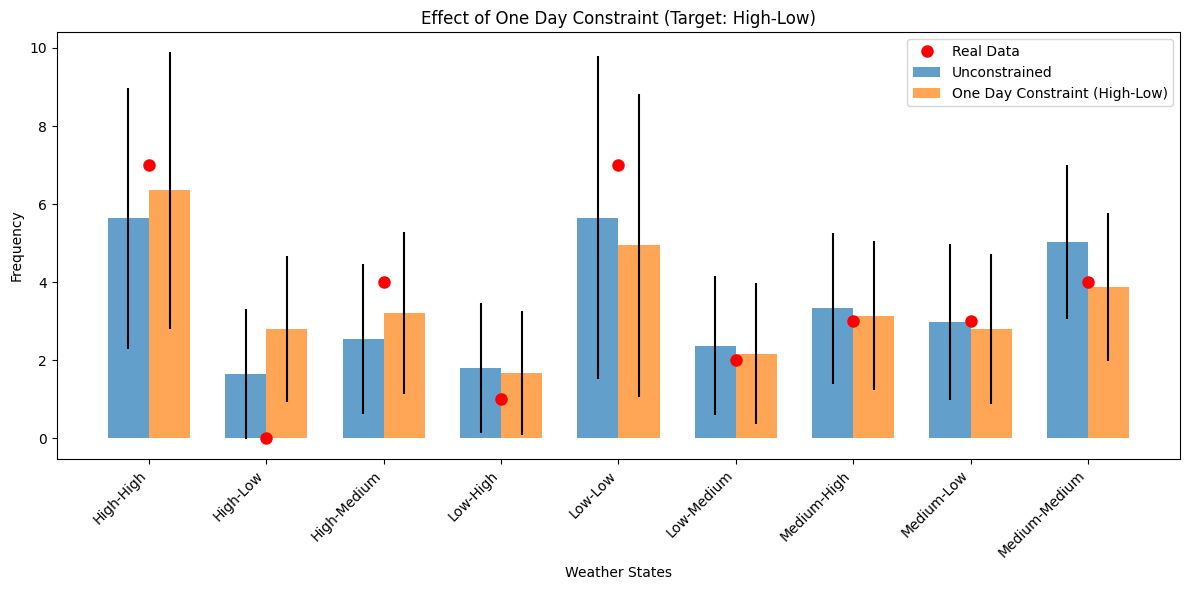

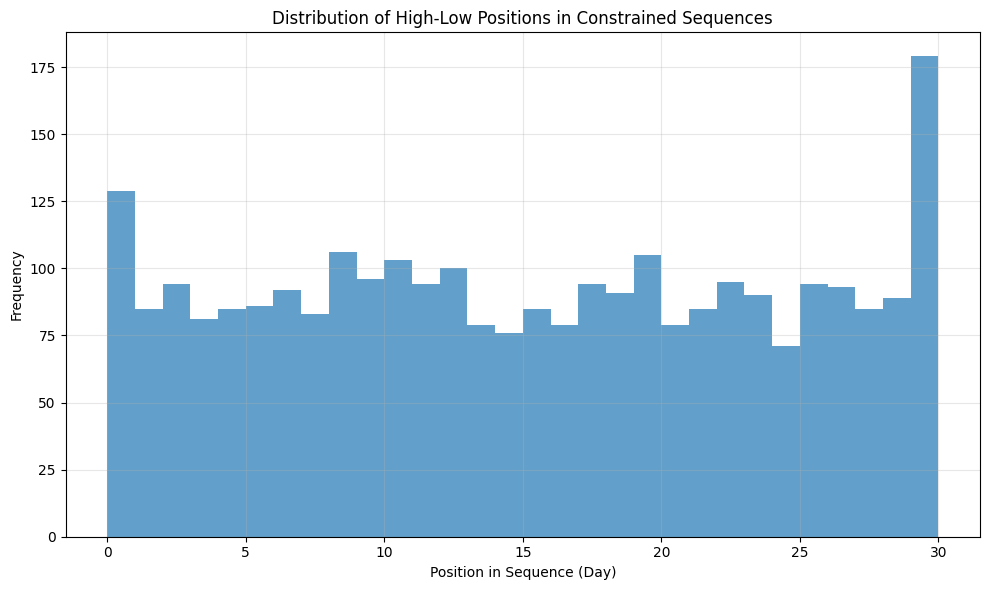

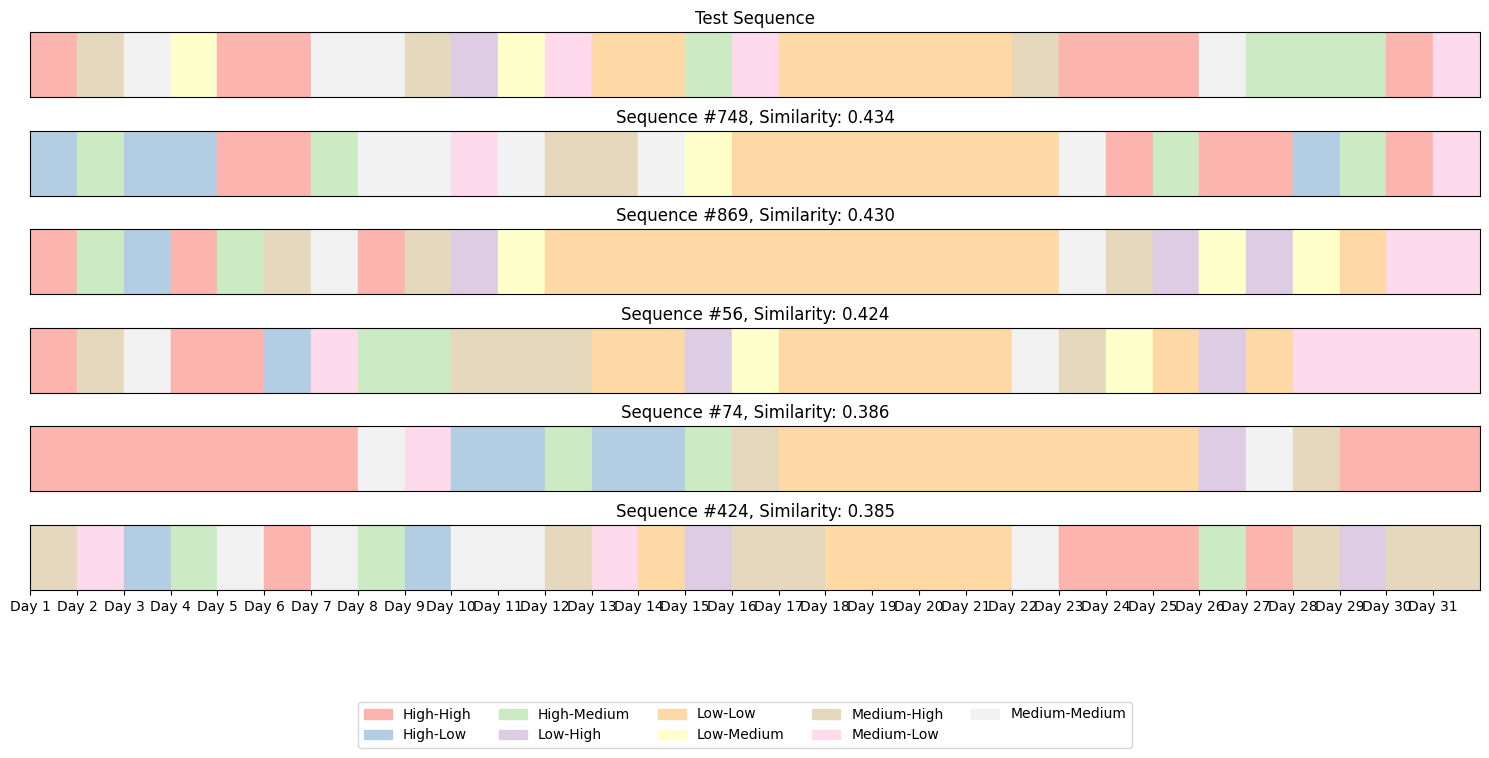

In [72]:
one_day_sim = test_one_day_constraint_monte_carlo()


In [ ]:
def test_one_day_constraint():
    """
    Test the one day constraint implementation
    """
    # Select a target state to ensure appears at least once
    target_state= 'Low-High'
    
    # Generate a sequence with the constraint
    constrained_sequence = generate_one_day_constraint_sequence(transition_matrix = transition_matrix, states=all_states, target_state= 'High-High', steps=30)
    
    # Check if constraint is satisfied
    constraint_satisfied = target_state in constrained_sequence
    
    # Count occurrences
    occurrences = constrained_sequence.count(target_state)
    
    print(f"Target state: {target_state}")
    print(f"Constraint satisfied: {constraint_satisfied}")
    print(f"Number of occurrences: {occurrences}")
    print(f"Generated sequence: {constrained_sequence}")
    
    return constrained_sequence

# Run the test
constrained_sequence = test_one_day_constraint()

Target state: Low-High
Constraint satisfied: True
Number of occurrences: 2
Generated sequence: [np.str_('Low-High'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Medium'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Medium-Low'), np.str_('High-Medium'), np.str_('High-High'), np.str_('High-Medium'), np.str_('Medium-Medium'), np.str_('Low-High'), np.str_('Low-Medium'), np.str_('High-Low'), np.str_('Medium-Medium'), np.str_('Medium-High'), np.str_('Medium-Medium'), np.str_('High-High'), np.str_('High-High'), np.str_('High-High'), np.str_('Medium-Medium'), np.str_('Medium-Low'), np.str_('High-Low'), np.str_('High-High'), np.str_('High-Low'), np.str_('High-High'), np.str_('High-High'), np.str_('High-High'), np.str_('High-High'), np.str_('Medium-Medium'), np.str_('Medium-Low')]


[np.str_('Low-High'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Medium'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Medium-Low'), np.str_('High-Medium'), np.str_('High-High'), np.str_('High-Medium'), np.str_('Medium-Medium'), np.str_('Low-High'), np.str_('Low-Medium'), np.str_('High-Low'), np.str_('Medium-Medium'), np.str_('Medium-High'), np.str_('Medium-Medium'), np.str_('High-High'), np.str_('High-High'), np.str_('High-High'), np.str_('Medium-Medium'), np.str_('Medium-Low'), np.str_('High-Low'), np.str_('High-High'), np.str_('High-Low'), np.str_('High-High'), np.str_('High-High'), np.str_('High-High'), np.str_('High-High'), np.str_('Medium-Medium'), np.str_('Medium-Low')]


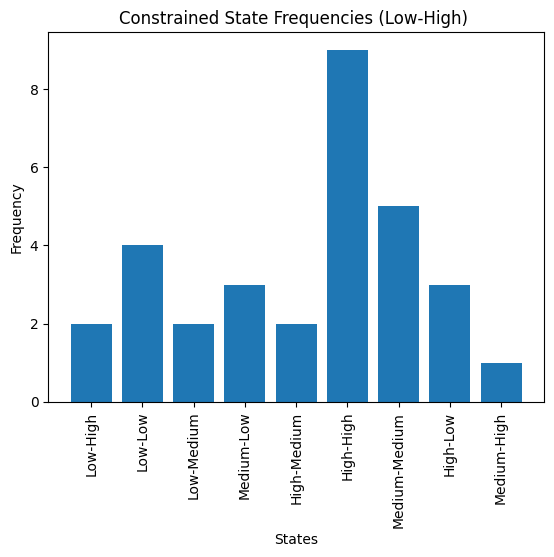

In [ ]:
print(constrained_sequence)



constrained_state_counts = Counter(constrained_sequence)



# Plot the state frequencies
plt.bar(constrained_state_counts.keys(), constrained_state_counts.values())
# plt.bar(state_counts_test.keys(), state_counts_test.values())
plt.xlabel('States')
plt.ylabel('Frequency')
plt.title('Constrained State Frequencies (Low-High) ')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# One-liner to split the states
temperature, precipitation = zip(*[str(state).split('-') for state in constrained_sequence])

# Convert to lists
temperature = list(temperature)
precipitation = list(precipitation)

print(len(constrained_sequence))

31


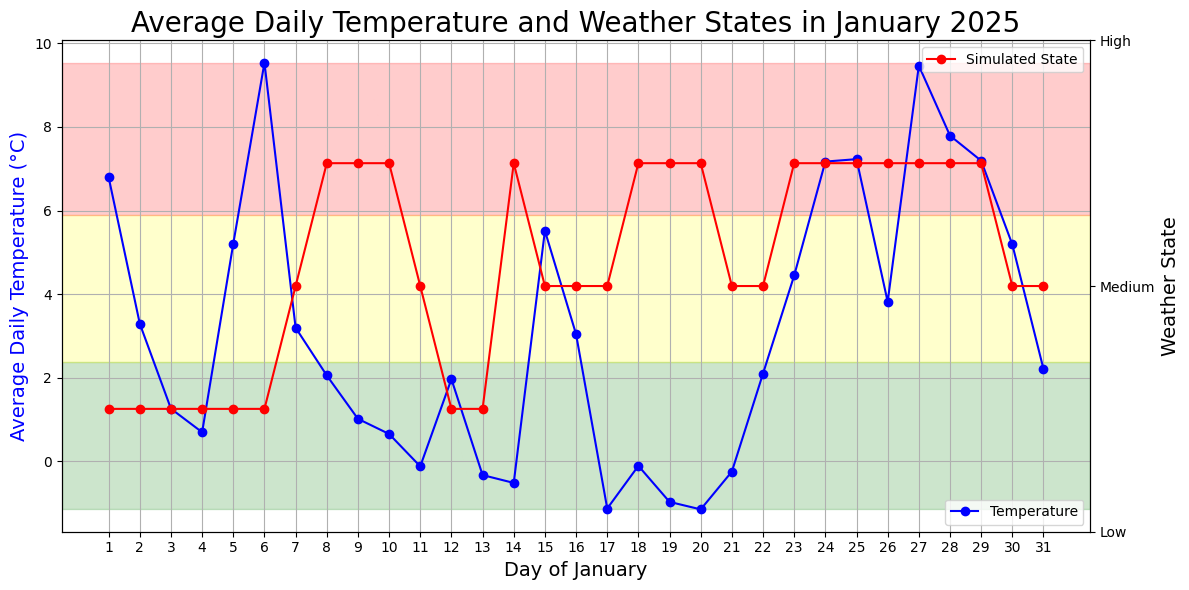

In [ ]:

# Example sequence
sequence = temperature

# Map the sequence to numerical values for plotting
sequence_mapping = {'Low': 2.5, 'Medium': 5, 'High': 7.5}
sequence_numeric = [sequence_mapping[state] for state in sequence]

# Plot the temperature data
weather_var = 'temp'
plt.figure(figsize=(12, 6))

# Plot the daily mean temperature
plt.plot(daily_mean_test_df['day'], daily_mean_test_df[weather_var], marker='o', label='Temperature', color='blue')
plt.xlabel('Day of January', size=14)
plt.ylabel('Average Daily Temperature (°C)', size=14, color='blue')
plt.title('Average Daily Temperature and Weather States in January 2025', size=20)
plt.xticks(daily_mean_test_df['day'])
plt.grid()
plt.legend(loc='lower right')

# Define thresholds for low, medium, and high levels
low_threshold = daily_mean_test_df[weather_var].min() + (daily_mean_test_df[weather_var].max() - daily_mean_test_df[weather_var].min()) * 0.33
high_threshold = daily_mean_test_df[weather_var].min() + (daily_mean_test_df[weather_var].max() - daily_mean_test_df[weather_var].min()) * 0.66

# Add horizontal bands for low, medium, and high levels
plt.axhspan(daily_mean_test_df[weather_var].min(), low_threshold, color='green', alpha=0.2, label='Low')
plt.axhspan(low_threshold, high_threshold, color='yellow', alpha=0.2, label='Medium')
plt.axhspan(high_threshold, daily_mean_test_df[weather_var].max(), color='red', alpha=0.2, label='High')

# # Add labels in the middle of the bands
# plt.text(0.5, (daily_mean_test_df[weather_var].min() + low_threshold) / 2, 'Low', color='black', fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
# plt.text(0.5, (low_threshold + high_threshold) / 2, 'Medium', color='black', fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
# plt.text(0.5, (high_threshold + daily_mean_test_df[weather_var].max()) / 2, 'High', color='black', fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))

# Add a secondary y-axis for the sequence
ax2 = plt.gca().twinx()
ax2.plot(daily_mean_test_df['day'], sequence_numeric, marker='o', color='red', label='Simulated State')
ax2.set_ylabel('Weather State', size=14, color='black')
ax2.set_yticks([0, 5, 10])
ax2.set_yticklabels(['Low', 'Medium', 'High'], color='black')
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

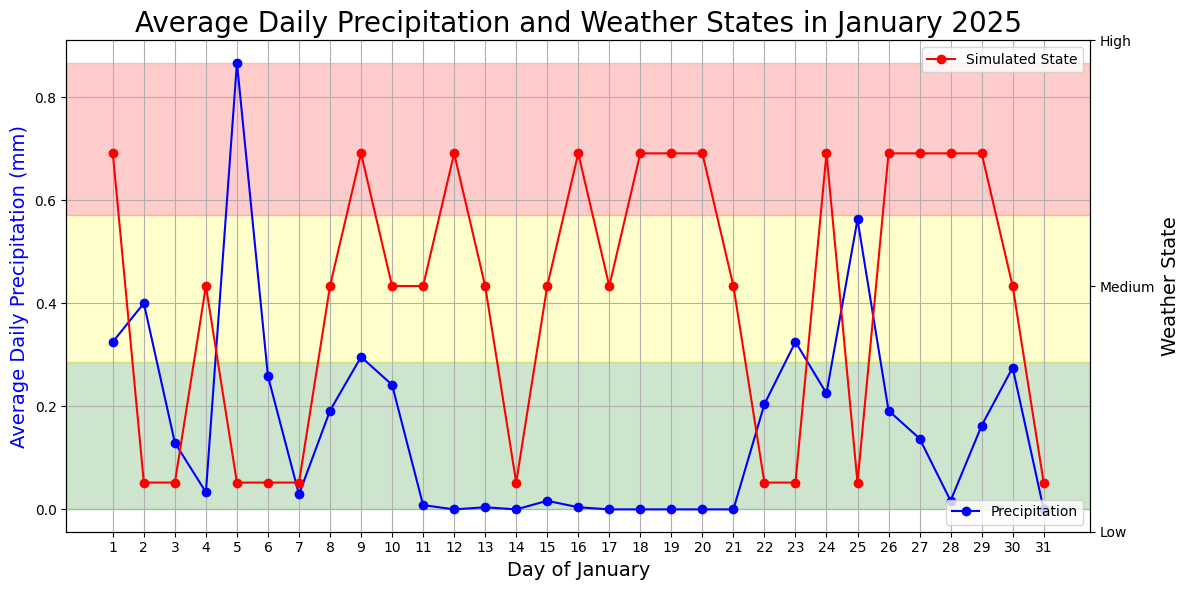

In [ ]:

# Example sequence
sequence = precipitation

# Map the sequence to numerical values for plotting
sequence_mapping = {'Low': 1, 'Medium': 5, 'High': 7.7}
sequence_numeric = [sequence_mapping[state] for state in sequence]

# Plot the temperature data
weather_var = 'precip'
plt.figure(figsize=(12, 6))

# Plot the daily mean temperature
plt.plot(daily_mean_test_df['day'], daily_mean_test_df[weather_var], marker='o', label='Precipitation', color='blue')
plt.xlabel('Day of January', size=14)
plt.ylabel('Average Daily Precipitation (mm)', size=14, color='blue')
plt.title('Average Daily Precipitation and Weather States in January 2025', size=20)
plt.xticks(daily_mean_test_df['day'])
plt.grid()
plt.legend(loc='lower right')

# Define thresholds for low, medium, and high levels
low_threshold = daily_mean_test_df[weather_var].min() + (daily_mean_test_df[weather_var].max() - daily_mean_test_df[weather_var].min()) * 0.33
high_threshold = daily_mean_test_df[weather_var].min() + (daily_mean_test_df[weather_var].max() - daily_mean_test_df[weather_var].min()) * 0.66

# Add horizontal bands for low, medium, and high levels
plt.axhspan(daily_mean_test_df[weather_var].min(), low_threshold, color='green', alpha=0.2, label='Low')
plt.axhspan(low_threshold, high_threshold, color='yellow', alpha=0.2, label='Medium')
plt.axhspan(high_threshold, daily_mean_test_df[weather_var].max(), color='red', alpha=0.2, label='High')

# # Add labels in the middle of the bands
# plt.text(0.5, (daily_mean_test_df[weather_var].min() + low_threshold) / 2, 'Low', color='black', fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
# plt.text(0.5, (low_threshold + high_threshold) / 2, 'Medium', color='black', fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
# plt.text(0.5, (high_threshold + daily_mean_test_df[weather_var].max()) / 2, 'High', color='black', fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))

# Add a secondary y-axis for the sequence
ax2 = plt.gca().twinx()
ax2.plot(daily_mean_test_df['day'], sequence_numeric, marker='o', color='red', label='Simulated State')
ax2.set_ylabel('Weather State', size=14, color='black')
ax2.set_yticks([0, 5, 10])
ax2.set_yticklabels(['Low', 'Medium', 'High'], color='black')
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

### No Days Constraint

In [80]:
def implement_no_days_constraint(transition_matrix, states, excluded_state):
    """
    Modify transition matrix to avoid a specific state
    
    Args:
        transition_matrix: Original transition matrix (Pandas DataFrame)
        states: List of possible states
        excluded_state: The state that must not appear
        
    Returns:
        Modified transition matrix
    """
    # Create a copy of the transition matrix
    modified_matrix = transition_matrix.copy()
    
    # Get index of excluded state
    excluded_idx = states.index(excluded_state)
    
    # Set all transitions to excluded state to zero
    for state in states:
        if state != excluded_state:  # Handle other states
            # Get current probability of transitioning to excluded state
            current_prob = modified_matrix.loc[state, excluded_state]
            
            if current_prob > 0:
                # Set transition to excluded state to zero
                modified_matrix.loc[state, excluded_state] = 0
                
                # Redistribute probability to other states
                other_states = [s for s in states if s != excluded_state]
                other_probs_sum = modified_matrix.loc[state, other_states].sum()
                
                if other_probs_sum > 0:  # Avoid division by zero
                    for other_state in other_states:
                        modified_matrix.loc[state, other_state] *= (1 + current_prob/other_probs_sum)
        
        else:  # Handle the excluded state itself
            # Handle case where initial state is the excluded state
            # Redistribute all probability to other states uniformly
            modified_matrix.loc[excluded_state] = 0
            for other_state in [s for s in states if s != excluded_state]:
                modified_matrix.loc[excluded_state, other_state] = 1.0 / (len(states) - 1)
    
    # Ensure rows still sum to 1
    for state in states:
        row_sum = modified_matrix.loc[state].sum()
        if abs(row_sum - 1.0) > 1e-10:  # If not very close to 1
            modified_matrix.loc[state] /= row_sum
    
    return modified_matrix

def generate_no_days_constraint_sequence(transition_matrix, states, excluded_state, 
                                        initial_state=None, steps=31):
    """
    Generate a sequence with no occurrences of excluded_state
    
    Args:
        transition_matrix: Your transition probability matrix (Pandas DataFrame)
        states: List of possible states
        excluded_state: State that must not appear
        initial_state: Starting state (if None, will be randomly selected)
        steps: Number of days to generate
        
    Returns:
        A sequence that contains no occurrences of excluded_state
    """
    # Modify transition matrix to avoid excluded state
    modified_matrix = implement_no_days_constraint(transition_matrix, states, excluded_state)
    
    # If no initial state is provided or if initial state is the excluded state, choose another one
    if initial_state is None or initial_state == excluded_state:
        available_states = [s for s in states if s != excluded_state]
        initial_state = np.random.choice(available_states)
        
    # Ensure initial_state is not None before passing to simulate_markov_chain
    if initial_state is None:
        raise ValueError("Initial state cannot be None")
        
    # Generate sequence with modified matrix
    sequence = simulate_markov_chain(modified_matrix, states, initial_state, steps)
    
    return sequence

In [81]:
def test_no_days_constraint():
    """
    Test the no days constraint implementation
    """
    # Select a state to exclude
    excluded_state = 'High-High'
    
    # Generate a sequence with the constraint
    constrained_sequence = generate_no_days_constraint_sequence(
        transition_matrix=transition_matrix, 
        states=all_states, 
        excluded_state=excluded_state, 
        steps=30)
    
    # Check if constraint is satisfied
    constraint_satisfied = excluded_state not in constrained_sequence
    
    # Count occurrences (should be 0)
    occurrences = constrained_sequence.count(excluded_state)
    
    print(f"Excluded state: {excluded_state}")
    print(f"Constraint satisfied: {constraint_satisfied}")
    print(f"Number of occurrences: {occurrences}")
    print(f"Generated sequence: {constrained_sequence}")
    
    return constrained_sequence


# Run the test
no_day_constrained_sequence = test_no_days_constraint()

Excluded state: High-High
Constraint satisfied: True
Number of occurrences: 0
Generated sequence: [np.str_('Medium-High'), np.str_('Medium-High'), np.str_('Medium-Medium'), np.str_('High-Medium'), np.str_('Medium-Medium'), np.str_('Medium-High'), np.str_('High-Medium'), np.str_('Medium-Medium'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-High'), np.str_('Low-High'), np.str_('Low-High'), np.str_('Low-High'), np.str_('Medium-Medium'), np.str_('Medium-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-High'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Medium-Low'), np.str_('High-Medium')]


[np.str_('Medium-High'), np.str_('Medium-High'), np.str_('Medium-Medium'), np.str_('High-Medium'), np.str_('Medium-Medium'), np.str_('Medium-High'), np.str_('High-Medium'), np.str_('Medium-Medium'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-High'), np.str_('Low-High'), np.str_('Low-High'), np.str_('Low-High'), np.str_('Medium-Medium'), np.str_('Medium-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-High'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Medium-Low'), np.str_('High-Medium')]


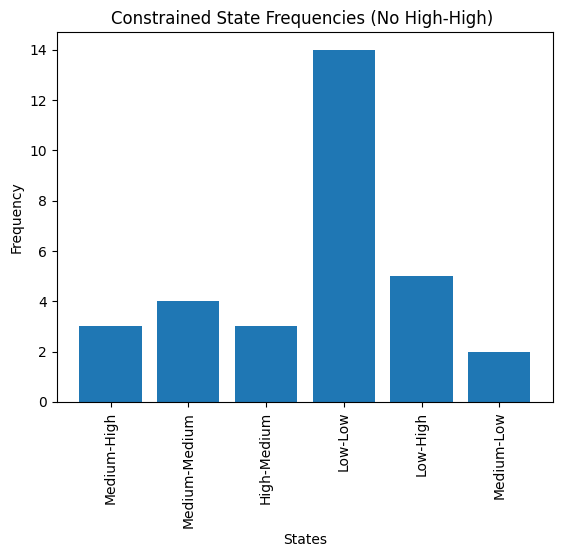

In [82]:
print(no_day_constrained_sequence)
no_day_constrained_state_counts = Counter(no_day_constrained_sequence)

# Plot the state frequencies
plt.bar(no_day_constrained_state_counts.keys(), no_day_constrained_state_counts.values())
# plt.bar(state_counts_test.keys(), state_counts_test.values())
plt.xlabel('States')
plt.ylabel('Frequency')
plt.title('Constrained State Frequencies (No High-High) ')
plt.xticks(rotation=90)
plt.show()

In [85]:
def monte_carlo_with_no_days_constraint(transition_matrix, states, excluded_state, 
                                       initial_state=None, steps=31, n_simulations=1000):
    """
    Performs Monte Carlo simulation with no days constraint
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states
        excluded_state: State that must not appear
        initial_state: Starting state (if None, will be randomly chosen)
        steps: Number of steps to simulate in each run
        n_simulations: Number of simulations to run
        
    Returns:
        Dictionary containing:
        - 'mean_counts': Average count of each state across all simulations
        - 'std_counts': Standard deviation of counts for each state
        - 'all_sequences': List of all simulated sequences
    """
    # Initialize storage for all simulations
    all_sequences = []
    all_counts = {state: [] for state in states}
    
    # Run n_simulations
    for _ in range(n_simulations):
        # Run one constrained simulation
        sequence = generate_no_days_constraint_sequence(
            transition_matrix, states, excluded_state, initial_state, steps)
        all_sequences.append(sequence)
        
        # Count occurrences of each state in this simulation
        counts = Counter(sequence)
        for state in states:
            all_counts[state].append(counts.get(state, 0))
    
    # Calculate statistics
    mean_counts = {state: np.mean(counts) for state, counts in all_counts.items()}
    std_counts = {state: np.std(counts) for state, counts in all_counts.items()}
    
    return {
        'mean_counts': mean_counts,
        'std_counts': std_counts,
        'all_sequences': all_sequences
    }

In [94]:
def analyze_no_days_constraint_effect(transition_matrix, states, excluded_state, 
                                     real_data=None, test_sequence=None, n_simulations=1000, steps=31):
    """
    Analyze the effect of the no days constraint by comparing with unconstrained model
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states  
        excluded_state: State that must not appear
        real_data: Optional dictionary or Counter with actual observed frequencies
        test_sequence: Optional test sequence to compare with simulated sequences
        n_simulations: Number of simulations to run
        steps: Number of steps to simulate in each run
        
    Returns:
        Dictionary with analysis metrics
    """
    # Import necessary libraries if not already imported
    from scipy.stats import chisquare
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Run Monte Carlo simulations
    print(f"Running Monte Carlo simulation with no days constraint for excluded state '{excluded_state}'...")
    constrained_results = monte_carlo_with_no_days_constraint(
        transition_matrix, states, excluded_state, steps=steps, n_simulations=n_simulations)
    
    print(f"Running Monte Carlo simulation without constraints for comparison...")
    unconstrained_results = monte_carlo_markov_chain(
        transition_matrix, states, steps=steps, n_simulations=n_simulations)
    
    # Extract statistical results
    constrained_means = constrained_results['mean_counts']
    constrained_stds = constrained_results['std_counts']
    
    unconstrained_means = unconstrained_results['mean_counts']
    unconstrained_stds = unconstrained_results['std_counts']
    
    # Calculate constraint satisfaction rate
    # Count sequences with at least one occurrence of excluded state
    constrained_sequences = constrained_results['all_sequences']
    unconstrained_sequences = unconstrained_results['all_sequences']
    
    const_with_excluded = sum(1 for seq in constrained_sequences if excluded_state in seq)
    unconst_with_excluded = sum(1 for seq in unconstrained_sequences if excluded_state in seq)
    
    const_satisfaction_rate = (1 - const_with_excluded / n_simulations) * 100  # Should be 100%
    unconst_satisfaction_rate = (1 - unconst_with_excluded / n_simulations) * 100
    
    # Prepare data for visualization (state comparison)
    plt.figure(figsize=(12, 6))
    x = np.arange(len(states))
    width = 0.35
    
    # Set means for visualization
    vis_const_means = [constrained_means.get(state, 0) for state in states]
    vis_unconst_means = [unconstrained_means.get(state, 0) for state in states]
    
    # Set standard deviations for error bars
    vis_const_stds = [constrained_stds.get(state, 0) for state in states]
    vis_unconst_stds = [unconstrained_stds.get(state, 0) for state in states]
    
    # Create bar plot
    plt.bar(x - width/2, vis_unconst_means, width, yerr=vis_unconst_stds, 
            label='Unconstrained', alpha=0.7)
    plt.bar(x + width/2, vis_const_means, width, yerr=vis_const_stds, 
            label=f'No Days Constraint ({excluded_state} excluded)', alpha=0.7)
    
    # Add real data if provided
    if real_data is not None:
        real_counts = [real_data.get(state, 0) for state in states]
        plt.plot(x, real_counts, 'ro', label='Real Data', markersize=8)
        
    # Format plot    
    plt.xlabel('Weather States')
    plt.ylabel('Frequency')
    plt.title(f'Effect of No Days Constraint (Excluded: {excluded_state})')
    plt.xticks(x, states, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig('no_days_constraint_analysis.png')
    
    # Calculate impact on excluded state frequency
    excluded_constrained = constrained_means.get(excluded_state, 0)  # Should be 0
    excluded_unconstrained = unconstrained_means.get(excluded_state, 0)
    excluded_diff = excluded_constrained - excluded_unconstrained
    
    # Calculate statistics
    # Prepare vectors for chi-square test
    const_vector = [constrained_means.get(state, 0) for state in states]
    unconst_vector = [unconstrained_means.get(state, 0) for state in states]
    
    # Run chi-square test
    chi2_stat, p_value = chisquare(const_vector, f_exp=unconst_vector)
    
    # Calculate mean absolute error between constrained and unconstrained
    mae = np.mean([abs(constrained_means.get(state, 0) - unconstrained_means.get(state, 0)) 
                  for state in states])
    
    # Calculate state impacts
    state_impacts = {}
    for state in states:
        diff = constrained_means.get(state, 0) - unconstrained_means.get(state, 0)
        state_impacts[state] = diff
    
    # Find states with largest changes
    sorted_impacts = sorted(state_impacts.items(), key=lambda x: abs(x[1]), reverse=True)
    
    # Analyze transition patterns
    # Identify states with significant transitions to excluded state in original model
    significant_from_states = []
    for state in states:
        if state != excluded_state:
            prob_to_excluded = transition_matrix.loc[state, excluded_state]
            if prob_to_excluded > 0.1:  # Threshold for "significant"
                significant_from_states.append((state, prob_to_excluded))
    
    # Add sequence comparison if a test sequence is provided
    sequence_comparison = None
    if test_sequence is not None:
        print("Comparing constrained sequences with test sequence...")
        sequence_comparison = compare_sequences_with_test(
            constrained_results['all_sequences'], test_sequence, states)
        
        # Rename sequence comparison file for this specific constraint
        import os
        if os.path.exists('sequence_comparison.png'):
            try:
                os.rename('sequence_comparison.png', 'no_days_sequence_comparison.png')
            except:
                print("Note: Could not rename sequence comparison file - it may be in use.")
    
    # Print summary statistics
    print("\n=== No Days Constraint Analysis Results ===")
    print(f"Excluded state: {excluded_state}")
    print(f"Constraint satisfaction:")
    print(f"  Constrained model: {const_satisfaction_rate:.1f}% of sequences exclude the target state")
    print(f"  Unconstrained model: {unconst_satisfaction_rate:.1f}% of sequences exclude the target state")
    
    print(f"\nExcluded state frequency:")
    print(f"  Unconstrained: {excluded_unconstrained:.2f} days")
    print(f"  Constrained: {excluded_constrained:.2f} days")
    print(f"  Difference: {excluded_diff:.2f} days")
    
    print(f"\nChi-square test:")
    print(f"  Chi-square statistic: {chi2_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Distributions are {'not ' if p_value < 0.05 else ''}statistically similar")
    
    print(f"\nDifference metrics:")
    print(f"  Mean absolute error: {mae:.4f}")
    
    print(f"\nStates with largest changes in frequency:")
    for state, change in sorted_impacts[:3]:
        print(f"  {state}: {change:+.4f}")
    
    print(f"\nStates with significant transitions to {excluded_state} in the original model:")
    if significant_from_states:
        for state, prob in sorted(significant_from_states, key=lambda x: x[1], reverse=True):
            print(f"  {state} → {excluded_state}: {prob:.3f}")
    else:
        print(f"  No states had significant transitions to {excluded_state}")
    
    # Return comprehensive results
    results = {
        'constrained_results': constrained_results,
        'unconstrained_results': unconstrained_results,
        'excluded_state': excluded_state,
        'const_satisfaction_rate': const_satisfaction_rate,
        'unconst_satisfaction_rate': unconst_satisfaction_rate,
        'state_impacts': state_impacts,
        'sorted_impacts': sorted_impacts,
        'chi2_stat': chi2_stat,
        'p_value': p_value,
        'mae': mae,
        'significant_transitions': significant_from_states,
        'sequence_comparison': sequence_comparison
    }
    
    return results

# Example function to test the implementation
def test_no_days_constraint_monte_carlo():
    """
    Test the no days constraint with Monte Carlo simulation
    """
    # Select a state to exclude
    excluded_state = 'High-High'  # Choose a state that appears frequently
    
    # Run the analysis
    analysis_results = analyze_no_days_constraint_effect(
        transition_matrix=transition_matrix,
        states=all_states,
        excluded_state=excluded_state,
        real_data=state_counts_test,  # Optional: your real January 2025 data
        test_sequence=state_sequence_test,  # Add your test sequence here
        n_simulations=1000,
        steps=31
    )
    
    print("\nMonte Carlo analysis of no days constraint completed!")
    return analysis_results
# Example function to test the implementation
def test_no_days_constraint_monte_carlo():
    """
    Test the no days constraint with Monte Carlo simulation
    """
    # Select a state to exclude
    excluded_state = 'High-High'  # Choose a state that appears frequently
    
    # Run the analysis
    analysis_results = analyze_no_days_constraint_effect(
        transition_matrix=transition_matrix,
        states=all_states,
        excluded_state=excluded_state,
        real_data=state_counts_test,  # Optional: your real January 2025 data
        test_sequence=state_sequence_test,  # Add your test sequence here
        n_simulations=1000,
        steps=31
    )
    
    print("\nMonte Carlo analysis of no days constraint completed!")
    return analysis_results

Running Monte Carlo simulation with no days constraint for excluded state 'Low-Low'...
Running Monte Carlo simulation without constraints for comparison...

=== No Days Constraint Analysis Results ===
Excluded state: Low-Low
Constraint satisfaction:
  Constrained model: 100.0% of sequences exclude the target state
  Unconstrained model: 12.2% of sequences exclude the target state

Excluded state frequency:
  Unconstrained: 5.26 days
  Constrained: 0.00 days
  Difference: -5.26 days

Chi-square test:
  Chi-square statistic: 6.8348
  p-value: 0.5546
  Distributions are statistically similar

Difference metrics:
  Mean absolute error: 1.1711

States with largest changes in frequency:
  Low-Low: -5.2620
  Medium-High: +1.1870
  Low-Medium: +0.8800

States with significant transitions to Low-Low in the original model:
  Low-Medium → Low-Low: 0.472
  Low-High → Low-Low: 0.250
  Medium-Low → Low-Low: 0.159


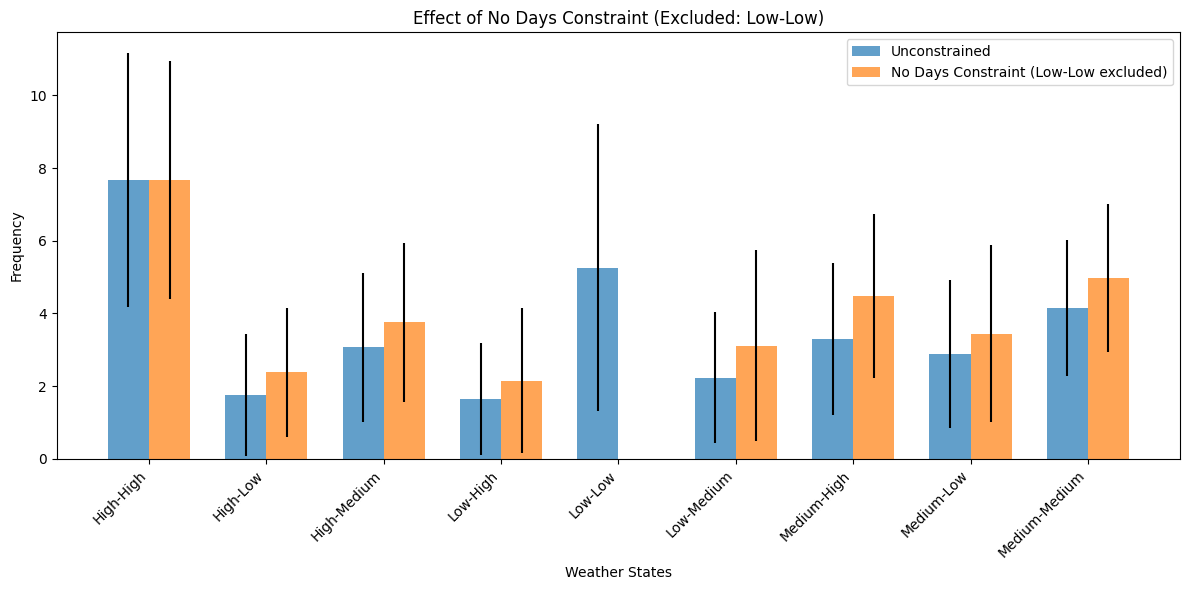

In [96]:
# Choose a state to exclude - preferably one that appears frequently in the unconstrained model
excluded_state = 'Low-Low'  # Or any other state you want to exclude

# Run the Monte Carlo analysis
no_days_analysis = analyze_no_days_constraint_effect(
    transition_matrix, 
    all_states, 
    excluded_state, 
    n_simulations=1000,  # Adjust based on computational resources
    steps=31  # For January
)

### K-Day Constraint

In [ ]:
def implement_k_exact_consecutive_days_constraint(transition_matrix, states, target_state, k, boost_factor=2.0):
    """
    Modify transition matrix to encourage exactly k consecutive occurrences of target_state
    
    Args:
        transition_matrix: Original transition matrix (Pandas DataFrame)
        states: List of possible states
        target_state: The state that must appear in exactly k consecutive days
        k: Number of consecutive days required
        boost_factor: Factor to increase transition probabilities
        
    Returns:
        Modified transition matrix
    """
    # Create a copy of the transition matrix
    modified_matrix = transition_matrix.copy()
    
    # 1. Boost transitions TO the target state from all other states
    for state in states:
        if state != target_state:
            # Get current probability of transitioning to target state
            current_prob = modified_matrix.loc[state, target_state]
            
            # Calculate boost amount
            boost = current_prob * (boost_factor - 1)
            
            # Add boost to target state transition
            modified_matrix.loc[state, target_state] += boost
            
            # Reduce other probabilities proportionally
            other_states = [s for s in states if s != target_state]
            other_probs_sum = modified_matrix.loc[state, other_states].sum()
            
            if other_probs_sum > 0:  # Avoid division by zero
                reduction_factor = (other_probs_sum - boost) / other_probs_sum
                for other_state in other_states:
                    modified_matrix.loc[state, other_state] *= reduction_factor
    
    # 2. Boost SELF-transition for target state to keep it for k-1 more times
    # but then ensure it transitions away after exactly k occurrences
    current_self_prob = modified_matrix.loc[target_state, target_state]
    
    # For exactly k occurrences, we want:
    # - High self-transition probability for the first k-1 transitions
    # - Then ensure transition away on the kth occurrence
    # This can't be fully captured in the transition matrix alone since it's state-based
    # So we do our best approximation in the matrix, and handle exact counts during sequence generation
    
    # For first k-1 transitions, boost self-transition
    min_prob = 0.8  # Higher probability to stay in state for k-1 times
    
    if current_self_prob < min_prob:
        boost = min_prob - current_self_prob
        
        # Set self-transition to higher probability
        modified_matrix.loc[target_state, target_state] = min_prob
        
        # Reduce other probabilities from target state proportionally
        other_states = [s for s in states if s != target_state]
        other_probs_sum = modified_matrix.loc[target_state, other_states].sum()
        
        if other_probs_sum > 0:  # Avoid division by zero
            reduction_factor = (other_probs_sum - boost) / other_probs_sum
            for other_state in other_states:
                modified_matrix.loc[target_state, other_state] *= reduction_factor
    
    # Ensure rows still sum to 1 (handle numerical precision issues)
    for state in states:
        row_sum = modified_matrix.loc[state].sum()
        if abs(row_sum - 1.0) > 1e-10:  # If not very close to 1
            modified_matrix.loc[state] /= row_sum
    
    return modified_matrix

def generate_k_exact_consecutive_days_sequence(transition_matrix, states, target_state, k, 
                                             initial_state=None, steps=31, max_attempts=100):
    """
    Generate a sequence with exactly k consecutive occurrences of target_state (no more, no less)
    
    Args:
        transition_matrix: Your transition probability matrix (Pandas DataFrame)
        states: List of possible states
        target_state: State that must appear in exactly k consecutive days
        k: Number of consecutive days required
        initial_state: Starting state (if None, will be randomly selected)
        steps: Number of days to generate
        max_attempts: Maximum number of attempts to generate sequence with constraint
        
    Returns:
        A sequence that contains exactly k consecutive occurrences of target_state
    """
    # Check if k is greater than the number of steps (impossible constraint)
    if k > steps:
        raise ValueError(f"Cannot have {k} consecutive days in a sequence of {steps} days")
    
    # First approach: Try to generate sequences that naturally satisfy the constraint
    for attempt in range(max_attempts):
        # Modify transition matrix with increasing boost factor as needed
        boost_factor = 2.0 + (attempt // 10) * 0.5
        modified_matrix = implement_k_exact_consecutive_days_constraint(
            transition_matrix, states, target_state, k, boost_factor)
        
        # If no initial state is provided, select one randomly
        if initial_state is None:
            initial_state = np.random.choice(states)
            
        # Generate sequence with modified matrix
        sequence = simulate_markov_chain(modified_matrix, states, initial_state, steps)
        
        # Check for exactly k consecutive occurrences
        # Find all runs of the target state
        runs = []
        current_run = 0
        
        for state in sequence:
            if state == target_state:
                current_run += 1
            else:
                if current_run > 0:
                    runs.append(current_run)
                    current_run = 0
        
        # Add the last run if there is one
        if current_run > 0:
            runs.append(current_run)
        
        # Check if there's a run of exactly k
        if k in runs:
            return sequence
    
    # If we've exhausted attempts, use direct insertion to guarantee constraint
    print(f"Warning: Could not generate sequence naturally after {max_attempts} attempts.")
    print("Using direct insertion method to guarantee constraint.")
    
    # Start with unconstrained sequence
    if initial_state is None:
        initial_state = np.random.choice(states)
    base_sequence = simulate_markov_chain(transition_matrix, states, initial_state, steps)
    
    # First ensure there are no runs of the target state longer than k-1
    # Break up any longer runs
    i = 0
    while i < len(base_sequence) - (k-1):
        # Check if we have a run longer than k-1
        is_long_run = True
        for j in range(k):
            if i+j >= len(base_sequence) or base_sequence[i+j] != target_state:
                is_long_run = False
                break
        
        # If we found a run of k or longer, break it up at position k
        if is_long_run:
            # Find a different state to insert
            other_states = [s for s in states if s != target_state]
            replacement_state = np.random.choice(other_states)
            base_sequence[i+k-1] = replacement_state
        
        i += 1
    
    # Now find a spot to insert exactly k consecutive occurrences
    max_start_position = len(base_sequence) - k
    insert_position = np.random.randint(0, max_start_position + 1)
    
    # Insert k consecutive target states
    for i in range(k):
        base_sequence[insert_position + i] = target_state
    
    # Verify the sequence has exactly one run of k consecutive occurrences
    runs = []
    current_run = 0
    
    for state in base_sequence:
        if state == target_state:
            current_run += 1
        else:
            if current_run > 0:
                runs.append(current_run)
                current_run = 0
    
    # Add the last run if there is one
    if current_run > 0:
        runs.append(current_run)
    
    # Double-check we have exactly one run of k
    k_count = runs.count(k)
    if k_count != 1:
        # This should not happen, but just in case, fix it
        print(f"Warning: After direct insertion, found {k_count} runs of exactly {k} consecutive days")
        print("Attempting to fix sequence...")
        
        # Start over with a new sequence
        return generate_k_exact_consecutive_days_sequence(
            transition_matrix, states, target_state, k, initial_state, steps)
    
    return base_sequence

def monte_carlo_with_k_exact_consecutive_days_constraint(transition_matrix, states, target_state, k,
                                                      initial_state=None, steps=31, n_simulations=1000):
    """
    Performs Monte Carlo simulation of a Markov Chain with exactly k consecutive days constraint
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states
        target_state: State that must appear exactly k consecutive times
        k: Number of consecutive days required
        initial_state: Starting state (if None, will be randomly chosen)
        steps: Number of steps to simulate in each run
        n_simulations: Number of simulations to run
        
    Returns:
        Dictionary containing:
        - 'mean_counts': Average count of each state across all simulations
        - 'std_counts': Standard deviation of counts for each state
        - 'ci_lower', 'ci_upper': 95% confidence intervals for state frequencies
        - 'all_sequences': List of all simulated sequences
        - 'run_distributions': Distribution of run lengths
    """
    # Initialize storage for all simulations
    all_sequences = []
    all_counts = {state: [] for state in states}
    run_distributions = {i: 0 for i in range(1, k+2)}  # Track runs of 1, 2, ..., k, k+1 or more
    
    # Run n_simulations
    for i in range(n_simulations):
        if i % 100 == 0 and i > 0:
            print(f"Completed {i}/{n_simulations} simulations...")
            
        # Generate sequence with constraint
        sequence = generate_k_exact_consecutive_days_sequence(
            transition_matrix, states, target_state, k, initial_state, steps)
        all_sequences.append(sequence)
        
        # Count occurrences of each state in this simulation
        counts = Counter(sequence)
        for state in states:
            all_counts[state].append(counts.get(state, 0))
            
        # Analyze run lengths
        runs = []
        current_run = 0
        
        for state in sequence:
            if state == target_state:
                current_run += 1
            else:
                if current_run > 0:
                    runs.append(current_run)
                    current_run = 0
        
        # Add the last run if there is one
        if current_run > 0:
            runs.append(current_run)
        
        # Update run distribution
        for run_length in runs:
            if run_length <= k:
                run_distributions[run_length] += 1
            else:
                run_distributions[k+1] += 1  # k+1 bucket counts runs longer than k
    
    # Calculate statistics
    mean_counts = {state: np.mean(counts) for state, counts in all_counts.items()}
    std_counts = {state: np.std(counts) for state, counts in all_counts.items()}
    
    # Calculate 95% confidence intervals
    ci_lower = {state: np.percentile(counts, 2.5) for state, counts in all_counts.items()}
    ci_upper = {state: np.percentile(counts, 97.5) for state, counts in all_counts.items()}
    
    return {
        'mean_counts': mean_counts,
        'std_counts': std_counts,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'all_sequences': all_sequences,
        'run_distributions': run_distributions
    }

def analyze_k_exact_consecutive_days_constraint_effect(transition_matrix, states, target_state, k, 
                                                    real_data=None, n_simulations=1000, steps=31):
    """
    Analyze the effect of the exactly k consecutive days constraint
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states  
        target_state: State that must appear exactly k consecutive times
        k: Number of consecutive days required
        real_data: Optional dictionary or Counter with actual observed frequencies
        n_simulations: Number of simulations to run
        steps: Number of steps to simulate in each run
        
    Returns:
        Dictionary with analysis metrics
    """
    # Run Monte Carlo simulations
    print(f"Running Monte Carlo simulation with exactly {k} consecutive days constraint for state '{target_state}'...")
    constrained_results = monte_carlo_with_k_exact_consecutive_days_constraint(
        transition_matrix, states, target_state, k, steps=steps, n_simulations=n_simulations)
    
    print(f"Running Monte Carlo simulation without constraints for comparison...")
    unconstrained_results = monte_carlo_markov_chain(
        transition_matrix, states, steps=steps, n_simulations=n_simulations)
    
    # Extract statistical results
    constrained_means = constrained_results['mean_counts']
    constrained_stds = constrained_results['std_counts']
    
    unconstrained_means = unconstrained_results['mean_counts']
    unconstrained_stds = unconstrained_results['std_counts']
    
    # Prepare data for visualization (state comparison)
    plt.figure(figsize=(12, 6))
    x = np.arange(len(states))
    width = 0.35
    
    # Set means for visualization
    vis_const_means = [constrained_means.get(state, 0) for state in states]
    vis_unconst_means = [unconstrained_means.get(state, 0) for state in states]
    
    # Set standard deviations for error bars
    vis_const_stds = [constrained_stds.get(state, 0) for state in states]
    vis_unconst_stds = [unconstrained_stds.get(state, 0) for state in states]
    
    # Create bar plot
    plt.bar(x - width/2, vis_unconst_means, width, yerr=vis_unconst_stds, 
            label='Unconstrained', alpha=0.7)
    plt.bar(x + width/2, vis_const_means, width, yerr=vis_const_stds, 
            label=f'Exactly {k} Consecutive Days ({target_state})', alpha=0.7)
    
    # Add real data if provided
    if real_data is not None:
        real_counts = [real_data.get(state, 0) for state in states]
        plt.plot(x, real_counts, 'ro', label='Real Data', markersize=8)
        
    # Format plot    
    plt.xlabel('Weather States')
    plt.ylabel('Frequency')
    plt.title(f'Effect of Exactly {k} Consecutive Days Constraint (Target: {target_state})')
    plt.xticks(x, states, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig('k_exact_consecutive_days_analysis.png')
    
    # Visualize the distribution of run lengths
    run_dist = constrained_results['run_distributions']
    run_lengths = list(run_dist.keys())
    run_counts = list(run_dist.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(run_lengths, run_counts, alpha=0.7, edgecolor='black')
    plt.axvline(x=k, color='red', linestyle='--', label=f'Constraint Requirement (k={k})')
    plt.xlabel('Run Length (Consecutive Occurrences)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Run Lengths for {target_state}')
    plt.xticks(run_lengths)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('k_exact_consecutive_days_run_distribution.png')
    
    # Calculate impact on target state frequency
    target_constrained = constrained_means.get(target_state, 0)
    target_unconstrained = unconstrained_means.get(target_state, 0)
    target_diff = target_constrained - target_unconstrained
    target_percent_change = (target_diff / target_unconstrained) * 100 if target_unconstrained > 0 else float('inf')
    
    # Calculate statistics
    # Prepare vectors for chi-square test
    const_vector = [constrained_means.get(state, 0) for state in states]
    unconst_vector = [unconstrained_means.get(state, 0) for state in states]
    
    # Run chi-square test
    chi2_stat, p_value = chisquare(const_vector, f_exp=unconst_vector)
    
    # Calculate mean absolute error between constrained and unconstrained
    mae = np.mean([abs(constrained_means.get(state, 0) - unconstrained_means.get(state, 0)) 
                  for state in states])
    
    # Calculate state impacts
    state_impacts = {}
    for state in states:
        diff = constrained_means[state] - unconstrained_means[state]
        state_impacts[state] = diff
    
    # Find states with largest changes
    sorted_impacts = sorted(state_impacts.items(), key=lambda x: abs(x[1]), reverse=True)
    
    # Check if the constraint was correctly enforced
    # Every sequence should have exactly one run of length k
    k_run_count = run_dist.get(k, 0)
    constraint_satisfaction_rate = (k_run_count / n_simulations) * 100
    
    # Print summary statistics
    print("\n=== Exactly K Consecutive Days Constraint Analysis Results ===")
    print(f"Target state: {target_state}")
    print(f"Required consecutive days (k): {k}")
    print(f"Constraint satisfaction: {constraint_satisfaction_rate:.1f}% of sequences have exactly one run of length {k}")
    
    print(f"\nTarget state frequency:")
    print(f"  Unconstrained: {target_unconstrained:.2f} days")
    print(f"  Constrained: {target_constrained:.2f} days")
    print(f"  Difference: {target_diff:+.2f} days ({target_percent_change:+.1f}%)")
    
    print(f"\nRun length distribution:")
    for run_length, count in sorted(run_dist.items()):
        if run_length <= k:
            print(f"  {run_length} consecutive days: {count} runs (across {n_simulations} sequences)")
        else:
            print(f"  {k+1}+ consecutive days: {count} runs (across {n_simulations} sequences)")
    
    print(f"\nChi-square test:")
    print(f"  Chi-square statistic: {chi2_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Distributions are {'not ' if p_value < 0.05 else ''}statistically similar")
    
    print(f"\nDifference metrics:")
    print(f"  Mean absolute error: {mae:.4f}")
    
    print(f"\nStates with largest changes in frequency:")
    for state, change in sorted_impacts[:3]:
        print(f"  {state}: {change:+.4f}")
    
    # Return comprehensive results
    return {
        'constrained_results': constrained_results,
        'unconstrained_results': unconstrained_results,
        'target_state': target_state,
        'k': k,
        'run_distributions': run_dist,
        'constraint_satisfaction_rate': constraint_satisfaction_rate,
        'state_impacts': state_impacts,
        'sorted_impacts': sorted_impacts,
        'chi2_stat': chi2_stat,
        'p_value': p_value,
        'mae': mae
    }

# Example function to test the implementation
def test_k_exact_consecutive_days_constraint(target_state='High-High', k=3):
    """
    Test the exactly k consecutive days constraint with a single sequence
    """
    # Generate a sequence with the constraint
    constrained_sequence = generate_k_exact_consecutive_days_sequence(
        transition_matrix=transition_matrix, 
        states=all_states, 
        target_state=target_state, 
        k=k, 
        steps=31)
    
    # Check if constraint is satisfied - look for runs of exactly k
    runs = []
    current_run = 0
    
    for state in constrained_sequence:
        if state == target_state:
            current_run += 1
        else:
            if current_run > 0:
                runs.append(current_run)
                current_run = 0
    
    # Add the last run if there is one
    if current_run > 0:
        runs.append(current_run)
    
    # Count runs of exactly k
    k_runs = runs.count(k)
    
    # Check if there are runs longer than k
    longer_runs = sum(1 for run in runs if run > k)
    
    # Count occurrences
    occurrences = constrained_sequence.count(target_state)
    
    print(f"Target state: {target_state}")
    print(f"Required consecutive days (k): {k}")
    print(f"Runs of target state: {runs}")
    print(f"Runs of exactly {k} consecutive days: {k_runs}")
    print(f"Runs longer than {k} consecutive days: {longer_runs}")
    print(f"Total occurrences: {occurrences}")
    print(f"Generated sequence: {constrained_sequence}")
    
    return constrained_sequence

# For Monte Carlo analysis
def test_k_exact_consecutive_days_constraint_monte_carlo(target_state='High-High', k=3):
    """
    Test the exactly k consecutive days constraint with Monte Carlo simulation
    """
    # Select a target state and k value
    target_state = 'High-High'  # State that should appear exactly k consecutive times
    k = 3  # Number of consecutive days required
    
    # Run the analysis
    analysis_results = analyze_k_exact_consecutive_days_constraint_effect(
        transition_matrix=transition_matrix,
        states=all_states,
        target_state=target_state,
        k=k,
        real_data=state_counts_test,  # Optional: your real January 2025 data if available
        n_simulations=1000,
        steps=31
    )
    
    print("\nMonte Carlo analysis of exactly k consecutive days constraint completed!")
    return analysis_results

Running Monte Carlo simulation with exactly 3 consecutive days constraint for state 'High-High'...
Completed 100/1000 simulations...
Completed 200/1000 simulations...
Completed 300/1000 simulations...
Completed 400/1000 simulations...
Completed 500/1000 simulations...
Completed 600/1000 simulations...
Completed 700/1000 simulations...
Completed 800/1000 simulations...
Completed 900/1000 simulations...
Running Monte Carlo simulation without constraints for comparison...

=== Exactly K Consecutive Days Constraint Analysis Results ===
Target state: High-High
Required consecutive days (k): 3
Constraint satisfaction: 126.4% of sequences have exactly one run of length 3

Target state frequency:
  Unconstrained: 5.53 days
  Constrained: 17.73 days
  Difference: +12.20 days (+220.4%)

Run length distribution:
  1 consecutive days: 954 runs (across 1000 sequences)
  2 consecutive days: 708 runs (across 1000 sequences)
  3 consecutive days: 1264 runs (across 1000 sequences)
  4+ consecutive days

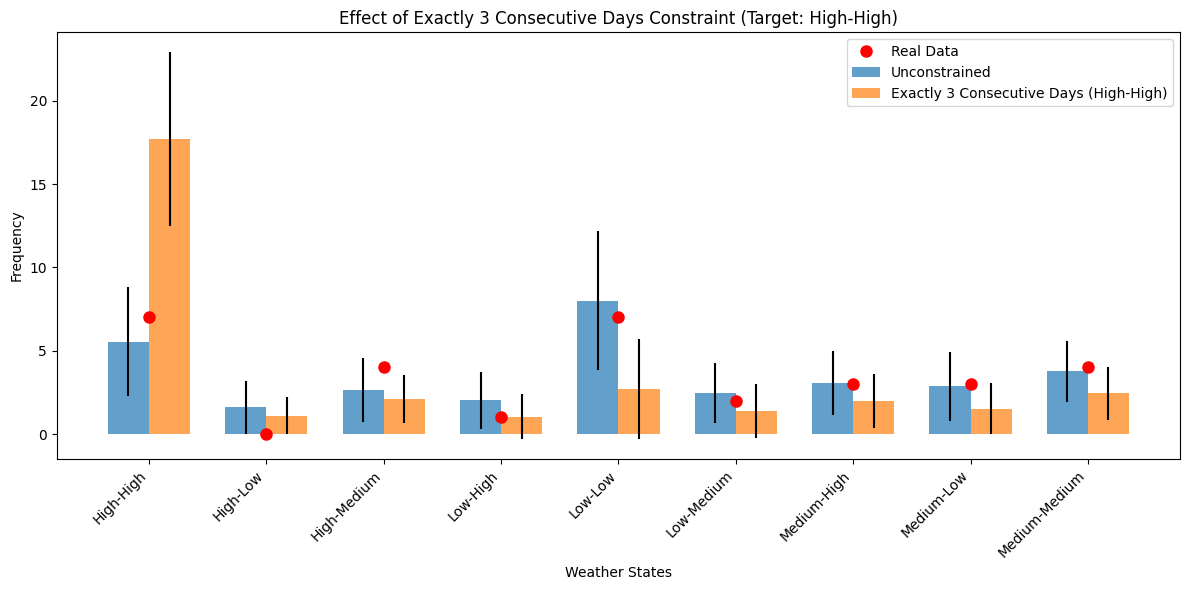

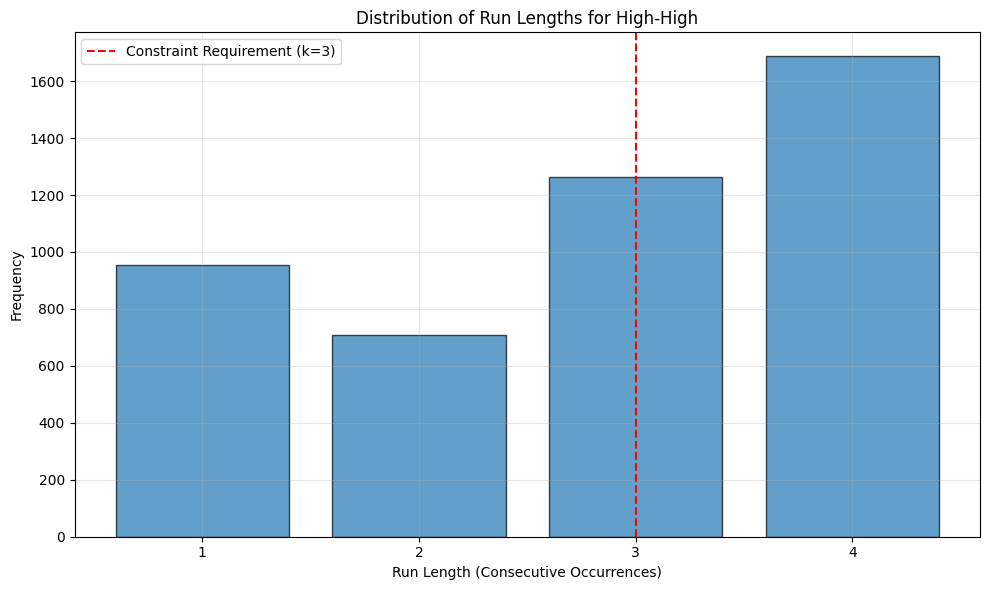

In [ ]:
# Generate a single test sequence
constrained_sequence = generate_k_exact_consecutive_days_sequence(
    transition_matrix=transition_matrix, 
    states=all_states, 
    target_state='High-High',  # Explicitly set target state
    k=3, 
    steps=31)

# Run Monte Carlo analysis
analysis_results = analyze_k_exact_consecutive_days_constraint_effect(
    transition_matrix=transition_matrix,
    states=all_states,
    target_state='High-High',  # Explicitly set target state
    k=3,
    real_data=state_counts_test,
    n_simulations=1000,
    steps=31
)